# Top-level imports

In [8]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard module is not an IPython extension.


#### import packages - setup

In [9]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from sklearn import metrics
import datetime
import tensorflow as tf

In [161]:
plt.style.use('fivethirtyeight')

In [11]:
data_dir = '../data/'

In [12]:
data_files = os.listdir(data_dir)
data_files.sort()
data_files

['BroughtonSeaLice_fishData.csv',
 'BroughtonSeaLice_fishInfo.csv',
 'BroughtonSeaLice_siteData.csv',
 'BroughtonSeaLice_siteInfo.csv',
 'DFOSeaLice_Data.csv',
 'DFOSeaLice_Info.csv',
 'IndustrySeaLice_Data.csv',
 'IndustrySeaLice_Info.csv',
 'README.md']

#### Wild data

In [13]:
fish_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishData.csv', encoding='ISO-8859-1')
site_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteData.csv', encoding='ISO-8859-1')

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
fish_info = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishInfo.csv', encoding='ISO-8859-1')
site_info = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteInfo.csv', encoding='ISO-8859-1')

#### Farm data

In [15]:
dfo_data = pd.read_csv(f'{data_dir}DFOSeaLice_Data.csv')
dfo_info = pd.read_csv(f'{data_dir}DFOSeaLice_Info.csv')

In [16]:
industry_data = pd.read_csv(f'{data_dir}IndustrySeaLice_Data.csv', encoding='ISO-8859-1', low_memory=False)
industry_info = pd.read_csv(f'{data_dir}IndustrySeaLice_Info.csv', encoding='ISO-8859-1', low_memory=False)

##### Data/Feature Engineering

Possible input scenarios
- 2001-2018: We have to trust that the model can work with the large amounts of NaN values in earlier years, both in wild data and no farmed data until 2011 
- 2003-2018: 2003 is the first year we have data starting in March


## Setting overall constants

Things to set here 
- Years to analyse
- Within-season date range
- Accepted ranges
- Resampling dates

In [17]:
analysis_years = list(range(2003, 2018))

In [18]:
analysis_months = list(range(3, 7))

In [19]:
dow_dict = {
    1: 'MON',
    2: 'TUE',
    3: 'WED',
    4: 'THU', 
    5: 'FRI', 
    6: 'SAT', 
    7: 'SUN'
}

def get_dow(dt_obj):
    dow_text = dt_obj.isoweekday()
    return(dow_dict[dow_text])

In [20]:
wild_locations = site_data['location'].unique()

## Setting up response

### Unified adult count
This is one possible response

In [21]:
adult = fish_data[['Lep_PAmale', 'Lep_PAfemale', 
                   'Lep_male', 'Lep_gravid',
                   'Lep_nongravid', 'unid_PA',
                   'unid_adult']].sum(axis=1)

In [22]:
fish_data_date = pd.to_datetime(fish_data[['year', 'day', 'month']])

In [23]:
response = pd.DataFrame({'count':adult.values, 
                         'location':fish_data['location'].values,
                         'datetime': fish_data_date})

In [24]:
response_glacier = response[response['location'] == 'Glacier']

In [25]:
year_df_list = []
for year in analysis_years:
    subset = response_glacier[response_glacier['datetime'].dt.year == year]
    subset.loc[0] = np.nan
    subset.loc[0, 'datetime'] = datetime.datetime(year, 1, 1)
    subset.loc[1] = np.nan
    subset.loc[1, 'datetime'] = datetime.datetime(year, 12, 31)
    subset.sort_values('datetime', inplace=True)
    subset_resampled = subset.resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                       on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_df_list.append(subset_resampled)
Y_glacier = pd.concat(year_df_list)

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [26]:
Y_glacier.to_csv('../xdata/Y_glacier.csv')

resample by week for average

This is the code I was formerly using for the resampling, it's pretty inconsistent

Y_glacier = response_glacier.resample('W', on='datetime', label='left').apply(np.nanmean)

## Setting up inputs - wild data

## Setting up inputs - wild data

In [27]:
# non-motile lice
juvenile = pd.DataFrame(fish_data[['Lep_cope', 'chalA',
                      'chalB', 'Caligus_cope',
                      'unid_cope', 'chal_unid']].sum(axis=1)).rename({0: 'count'}, axis=1)
juvenile['datetime'] = fish_data_date
juvenile['location'] = fish_data['location']

In [28]:
year_juv_list = []
for year in analysis_years:
    subset = juvenile[juvenile['datetime'].dt.year == year]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'count': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'count': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_juv_list.append(subset_resample)
X_wild_juv = pd.concat(year_juv_list)

In [29]:
X_wild_juv.to_csv('../xdata/X_wild_juv.csv')

This is the code I was previously using to resample the juvenile counts, now outdated

X_wild_juv = juvenile.groupby('location').resample('W', on='datetime', label='left').apply(np.nanmean)

Reducing dimensionality - averaging is probably okay

In [30]:
site_data['datetime'] = pd.to_datetime(site_data[['year', 'month', 'day']])

In [31]:
year_temp_list = []
for year in analysis_years:
    subset = site_data.loc[(site_data['datetime'].dt.year == year), ['datetime', 'temp', 'location']]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'temp': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'temp': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_temp_list.append(subset_resample)
X_wild_temp = pd.concat(year_temp_list)

In [32]:
X_wild_temp.to_csv('../xdata/X_wild_temp.csv')

This is how I used to get these inputs, now outdated

X_wild_temp = site_data[['datetime', 'temp', 'location']]
X_wild_temp = X_wild_temp.groupby('location').resample('w', on='datetime', label='left').apply(np.nanmean)

In [33]:
year_sal_list = []
for year in analysis_years:
    subset = site_data.loc[(site_data['datetime'].dt.year == year), ['datetime', 'salt', 'location']]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'salt': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'salt': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(method='linear')
    year_sal_list.append(subset_resample)
X_wild_sal = pd.concat(year_sal_list)

In [34]:
X_wild_sal.to_csv('../xdata/X_wild_sal.csv')

How I used to get these inputs, now outdated

X_wild_sal = site_data[['datetime', 'salt', 'location']]
X_wild_sal = X_wild_sal.groupby('location').resample('w', on='datetime', label='left').apply(np.nanmean)

## Setting up inputs - farm data

- There are of course concerns with using the industry counts as they *may* be of very low quality (I need to look much more extensively into this data)
    - Should look into what kind of predictive differences including/excluding these has 

Inputs that we want

44 - Sargeunts Pass

41 - Doctor Islet

45 - Humphrey Rock

56 - Glacier Falls

54 - Simoom Sound

50 - Burdwood Islands

53 - Sir Edmond Bay

49 - Wicklow Point 

In [35]:
industry_data[industry_data['Site Common Name'].str.contains('Sir')]['Site Common Name'].unique()
# Can't find Simoom Sound??

array(['Sir Edmund Bay'], dtype=object)

To reduce dimensionality:

Sum farm data, implementing # of fish for some sort of area infection indicator

In [36]:
relevant_farms = ['Sargeaunt Pass',
                  'Doctor Islets',
                  'Humphrey Rock',
                  'Simoom Sound*',
                  'Burdwood',
                  'Glacier Falls',
                  'Sir Edmund Bay',
                  'Wicklow Point'
                 ]
relevant_farms_iterable = ['Sargeaunt Pass',
                           'Doctor Islets',
                           'Humphrey Rock',
                           'Burdwood',
                           'Glacier Falls',
                           'Sir Edmund Bay',
                           'Wicklow Point'
                          ]


In [37]:
industry_data[industry_data['Site Common Name'].str.contains('|'.join(relevant_farms))]['Site Common Name'].unique()

array(['Burdwood', 'Sir Edmund Bay', 'Doctor Islets', 'Glacier Falls',
       'Wicklow Point', 'Sargeaunt Pass', 'Humphrey Rock',
       'Wicklow Point - post treatment', 'Wicklow Point - pre treatment',
       'Wicklow Point - post-treatment', 'Wicklow Point - pre-treatment'],
      dtype=object)

From what I can tell - most of these farms don't actually have a treatment indicator

Wondering if this is significant? 

I also can't find Simoom Sound, maybe it's here under a different name? 

In [38]:
comments_examples = industry_data[industry_data['Site Common Name'] == 'Burdwood']['Comments'].unique()

This is how I was resampling the industry data before

X_industry = relevant_farm_data[['datetime',
                            'Site Common Name',
                            'Average L. salmonis motiles per fish',
                            'Average chalimus per fish']]
X_industry = X_industry.groupby('Site Common Name').resample('W', on='datetime', label='left').mean()

The "Recent failure to control sea louse..." paper should have all the data I need until 2015

In [39]:
relevant_farm_data = industry_data[industry_data['Site Common Name'].str.contains('|'.join(relevant_farms))]

relevant_farm_data['Day'] = 1
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
relevant_farm_data['month'] = relevant_farm_data['Month'].map(month_map)
relevant_farm_data['datetime'] = pd.to_datetime(relevant_farm_data[['Year', 'month', 'Day']])

relevant_farm_data = relevant_farm_data[relevant_farm_data['datetime'].dt.year.isin(analysis_years)]

year_industry_list = []
for year in analysis_years:
    subset = relevant_farm_data.loc[(relevant_farm_data['datetime'].dt.year == year), 
                                   ['datetime', 'Site Common Name', 'Average L. salmonis motiles per fish']]
    
    for i, farm in enumerate(relevant_farms_iterable):
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'Site Common Name': farm,
            'Average L. salmonis motiles per fish': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'Site Common Name': farm,
            'Average L. salmonis motiles per fish': np.nan
        }, ignore_index=True)
            
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('Site Common Name').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                                 on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_industry_list.append(subset_resample)
X_industry = pd.concat(year_industry_list)


/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [40]:
X_industry.to_csv('../xdata/X_industry.csv')

### Forming array for model input

In [286]:
arrays_to_stack = []

for year in analysis_years:
    juv_sub = np.nanmean(X_wild_juv[(X_wild_juv.index.get_level_values(1).year == year) & 
                         X_wild_juv.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    temp_sub = np.nanmean(X_wild_temp[(X_wild_temp.index.get_level_values(1).year == year) & 
                           X_wild_temp.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    sal_sub = np.nanmean(X_wild_sal[(X_wild_sal.index.get_level_values(1).year == year) & 
                         X_wild_sal.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    ind_sub = np.nanmean(X_industry[(X_industry.index.get_level_values(1).year == year) & 
                         X_industry.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    
    year_array = np.column_stack((juv_sub, temp_sub, sal_sub, ind_sub))
    arrays_to_stack.append(year_array)
    
X = np.stack(arrays_to_stack, axis=0)

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [42]:
arrays_to_stack = []

for year in analysis_years:
    year_Y = Y_glacier[(Y_glacier.index.year == year) & 
                       Y_glacier.index.month.isin(analysis_months)].values
    arrays_to_stack.append(year_Y)
    
Y = np.stack(arrays_to_stack, axis=0)

In [43]:
Y.shape

(15, 17, 1)

### Exporting data to R

Work in progress - probably to go with the .py migration

Saving the data to be sent to R, this is to ensure that I'm using the same data for both analyses

# Experimenting with models

## Import packages and set up functions

Write normalising functions here (let's go with MinMaxScaling for future implementations)

## Setup Data

### Normalise and fill NAs

Log transform?

In [44]:
from sklearn.preprocessing import MinMaxScaler

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
Y_scale = np.nan_to_num(Y_scale)

### Split into train and test

In [210]:
train_X = X_scale[:-3]
train_Y = Y_scale[:-3]

test_X = X_scale[-3:]
test_Y = Y_scale[-3:]

## Baseline

### Overall Avg

Average over all years

### Naive seasonal

In [47]:
def naive_seasonal(year: int, reference_data: pd.DataFrame):
    '''
    Naive seasonal model
    This model takes a year to be predicted in and returns the last known year's values
    
    year: Year to be predicted
    reference_data: Pandas dataframe of the test/input Y data, must have a DatetimeIndex index
    '''
    
    
    pred_subset = reference_data[reference_data.index.year == year]
    preds = pred_subset[pred_subset.index.month.isin(analysis_months)]
    
    return(np.array(preds))

## Non-parametric

Some high level notes
- This analysis is very rough and is in no way final!!!
- The normalising, feature engineering, etc. is probably the roughest part of all of this. I don't expect it to have an effect on model choice but by no means should the input/output data be taken verbatim as what I intend to use
- Optimizers: some reading has shown that RMSprop is the suggested optimiser for RNNs, this also coincides with François Chollet's use of optimisers so for now I am going with this one for RNNs and ADAM as the default for all others. This requires further research!
- Reference points: 
     - ARIMA
     - Mean & SD

### Setting up tensorboard logs

### LSTM

Notes on LSTM

- Migrate to .py
- Export model
- Vs. mean & Bayes
- Model comparison



In [48]:
!rm -rf ./logs/ 
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [211]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.LSTM(32, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss='mse')

history = model.fit(train_X, train_Y, 
                    epochs=500, batch_size=16,)
                    #validation_split=0.2,)
                    #callbacks=[tensorboard_callback])

Epoch 1/500
12/12 [==============================] - 5s 444ms/sample - loss: 0.7397
Epoch 2/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.6991
Epoch 3/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.6502
Epoch 4/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.6011
Epoch 5/500
12/12 [==============================] - 0s 3ms/sample - loss: 0.5658
Epoch 6/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.5482
Epoch 7/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.5077
Epoch 8/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.4646
Epoch 9/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.4375
Epoch 10/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.3919
Epoch 11/500
12/12 [==============================] - 0s 3ms/sample - loss: 0.3769
Epoch 12/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.3606
Epoch 13/50

Epoch 100/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1941
Epoch 101/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1776
Epoch 102/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1786
Epoch 103/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1897
Epoch 104/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.2000
Epoch 105/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1660
Epoch 106/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1825
Epoch 107/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1831
Epoch 108/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1744
Epoch 109/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1970
Epoch 110/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1792
Epoch 111/500
12/12 [==============================] - 0s 2ms/sample - loss:

Epoch 198/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1507
Epoch 199/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1558
Epoch 200/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1555
Epoch 201/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1670
Epoch 202/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1456
Epoch 203/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1575
Epoch 204/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1590
Epoch 205/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1436
Epoch 206/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1623
Epoch 207/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1625
Epoch 208/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1444
Epoch 209/500
12/12 [==============================] - 0s 2ms/sample - loss:

Epoch 296/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1196
Epoch 297/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1274
Epoch 298/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1281
Epoch 299/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1210
Epoch 300/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1329
Epoch 301/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1304
Epoch 302/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1318
Epoch 303/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1186
Epoch 304/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1307
Epoch 305/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1214
Epoch 306/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1267
Epoch 307/500
12/12 [==============================] - 0s 2ms/sample - loss:

Epoch 394/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1098
Epoch 395/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1106
Epoch 396/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.0989
Epoch 397/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1094
Epoch 398/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1069
Epoch 399/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1103
Epoch 400/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1100
Epoch 401/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1088
Epoch 402/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1079
Epoch 403/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.0908
Epoch 404/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1006
Epoch 405/500
12/12 [==============================] - 0s 2ms/sample - loss:

Epoch 492/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.0855
Epoch 493/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.0980
Epoch 494/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.1004
Epoch 495/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.0888
Epoch 496/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.0856
Epoch 497/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.0984
Epoch 498/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.0915
Epoch 499/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.0939
Epoch 500/500
12/12 [==============================] - 0s 2ms/sample - loss: 0.0865


In [182]:
# %tensorboard --logdir logs/fit

In [212]:
train_predictions = model.predict(train_X)

# Train RMSE
metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                           train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))

0.05951712995033733

In [213]:
test_predictions = model.predict(test_X)

# Test RMSE
metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                           test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))

0.15900157517199698

In [186]:
def plot_predicted_vs_test(pred: np.ndarray, test: np.ndarray):
    fig, ax = plt.subplots(nrows=1, ncols=len(pred))
    fig.set_figwidth(14)
    
    for i in range(len(pred)):
        ax[i].plot(pred[i], color='black')
        ax[i].plot(test[i], color='gray')
        ax[i].set_title(i)
            

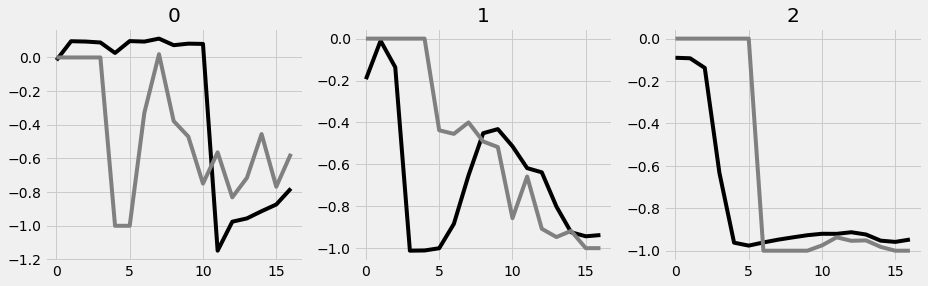

In [187]:
plot_predicted_vs_test(test_predictions, test_Y)

### Run LSTM on LOOCV sets + plot test predictions

In [215]:
from sklearn.preprocessing import MinMaxScaler

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
Y_scale = np.nan_to_num(Y_scale)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.LSTM(32, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss='mse')


fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(20)
for j, year in enumerate(analysis_years):
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = X_scale[ind]
    train_Y = Y_scale[ind]

    test_X = X_scale[j].reshape(1, X_scale.shape[1], X_scale.shape[2])
    test_Y = Y_scale[j].reshape(1, Y_scale.shape[1], Y_scale.shape[2])
    
    history = model.fit(train_X, train_Y, 
                    epochs=500, batch_size=16,)
    
    train_predictions = model.predict(train_X)

    # Train RMSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    print('###################')
    print(f'Train MSE for {year} is {train_mse}')
    print(f'Test MSE for {year} is {test_mse}')
    print('###################')
    
    jx = np.unravel_index(j, ax.shape)
    ax[jx].plot(test_predictions[0], color='black')
    ax[jx].plot(test_Y[0], color='gray')
    ax[jx].set_title(year)

### Test LSTM on very incomplete data

Note to self:

in X, each of these indices correspond to these predictors:

0: non-motiles

1: temperature

2: salinity

3: industry counts

#### Remove industry counts on test

Epoch 1/500
14/14 [==============================] - 8s 584ms/sample - loss: 0.6286
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5836
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5462
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4852
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4515
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4132
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3543
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3284
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3041
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.2884
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.2879
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3043
Epoch 13/50

Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1812
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1668
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1780
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1829
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1811
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1746
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1727
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1717
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1697
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1631
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1697
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1431
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1347
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1393
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1547
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1460
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1383
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1448
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1464
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1523
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1521
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1424
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1189
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1228
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1297
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1281
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1139
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1094
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1234
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1217
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1067
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1134
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1143
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0973
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1011
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1061
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1024
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0942
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1080
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1151
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1094
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0927
Epoch 403/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1104
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1087
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0846
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0990
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0868
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0981
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0888
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0805
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0814
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0890
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0820
###################
Train MSE for 2003 is 0.054154090410928724
Test MSE for 2003 is 0.19725287604288877
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0718
Epoch 2/500
14/14 [===================

Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0659
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0635
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0616
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0697
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0630
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0670
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0691
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0665
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0630
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0618
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0668
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0545
Ep

Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0555
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0635
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0612
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0497
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0623
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0567
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0608
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0610
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0582
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0546
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0631
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0484
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0534
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0540
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0481
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0519
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0581
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0610
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0456
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0543
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0530
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0565
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0518
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0507
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0477
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0551
Epoch 392/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0479
Epoch 393/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0536
Epoch 394/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0477
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0459
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0512
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0486
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0432
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0465
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0428
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0440
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0559
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0669
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0710
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0666
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0650
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0676
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0849
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0816
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0660
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0758
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0704
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0662
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0794
Epoch 91/500
14/1

Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0733
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0644
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0624
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0577
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0733
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0683
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0610
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0608
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0626
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0608
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0604
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0614
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0530
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0579
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0606
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0612
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0630
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0507
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0541
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0663
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0491
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0554
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0507
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0439
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0559
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0478
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0527
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0549
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0539
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0462
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0443
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0453
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0497
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0490
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0480
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0459
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0510
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0461
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0530
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0466
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0617
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0538
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0411
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0475
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0421
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0433
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0400
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoc

Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0426
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0478
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0465
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0403
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0440
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0403
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0403
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0319
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0355
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0388
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0312
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0332
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 469/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 470/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0457
Epoch 471/500
14/14 [==============================] - 0s 3ms/sample - loss:

Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0401
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0319
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0345
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0332
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0345
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 

Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0350
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0351
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 48/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 49/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoc

Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 147/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 148/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0301
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 245/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 343/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 344/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 441/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 442/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0293
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 38/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 39/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 40/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 41/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 42/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 43/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 44/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 45/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoc

Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 137/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 138/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 139/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 140/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 141/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 142/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 143/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 144/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 235/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 236/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 237/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 238/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 239/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 240/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 241/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 242/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 333/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 334/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 335/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 336/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 337/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 338/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 339/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 340/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 431/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 432/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 433/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 434/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 435/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 436/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 437/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 438/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 28/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 29/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 30/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 31/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 32/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 33/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 34/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 35/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0174
Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoc

Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 127/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 128/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 129/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 130/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 131/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 132/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 133/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 134/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 225/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 226/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 227/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 228/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 229/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 230/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 231/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 232/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 323/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0160
Epoch 324/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 325/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 326/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 327/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 328/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 329/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 330/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 421/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 422/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 423/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 424/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 425/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 426/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 427/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 428/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 17/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 18/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 19/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 20/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 21/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 22/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0161
Epoch 23/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 24/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 25/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoc

Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 116/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 117/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 118/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 119/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 120/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 121/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 122/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 123/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 124/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 214/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 215/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 216/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 217/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0264
Epoch 218/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 219/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 220/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 221/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 222/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 311/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0287
Epoch 312/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0232
Epoch 313/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0206
Epoch 314/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0268
Epoch 315/500
14/14 [==============================] - 0s 4ms/sample - loss: 0.0256
Epoch 316/500
14/14 [==============================] - 0s 4ms/sample - loss: 0.0201
Epoch 317/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0205
Epoch 318/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0204
Epoch 319/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0267
Epoch 320/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0208
Epoch 321/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0212
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 409/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0258
Epoch 410/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 411/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 412/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 413/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 414/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 415/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 416/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0209
Epoch 417/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 418/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 6/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0274
Epoch 7/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0210
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 9/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0231
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 13/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 14/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0144
Epoch 15/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0174
Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 17/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 18

Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 111/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0194
Epoch 112/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 113/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0296
Epoch 114/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 116/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 210/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 211/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 212/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 214/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 308/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 309/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 310/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 312/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 403/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0208
Epoch 404/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0170
Epoch 405/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0162
Epoch 406/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 407/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 408/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 410/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
###################
Train MSE for 2012 is 0.0024141988125399123
Test MSE for 2012 is 0.06233420805253322
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 7/500
14/14 [============================

Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0174
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0189
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 103/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0257
Epoch 104/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0248
Epoch 105/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0249
Epoch 106/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.02

Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 194/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0216
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0143
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 198/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0209
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 201/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0218
Epoch 202/500
14/14 [==============================] - 0s 4ms/sample - loss: 0.0241
Epoch 203/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0192
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0164
Epoch 293/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0173
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0159
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0147
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0165
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 4ms/sample - loss: 0.0162
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0174
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 88/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0181
Epoch 89/500
14/14 [==============================] - 0s 4ms/sample - loss: 0.0257
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 93/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0254
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 96/500
14/1

Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 191/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0179
Epoch 192/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0212
Epoch 193/500
14/14 [==============================] - 0s 3ms/sample - loss:

Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 283/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0180
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 286/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0200
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0166
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0168
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0167
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 480/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0162
Epoch 481/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0163
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 483/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0218
Epoch 484/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0191
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0345
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 85/500
14/1

14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0159
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 

Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0174
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0161
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 469/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 470/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0295
Epoc

Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0160
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 264/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0167
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0161
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0160
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0152
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 

Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0149
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0158
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss:

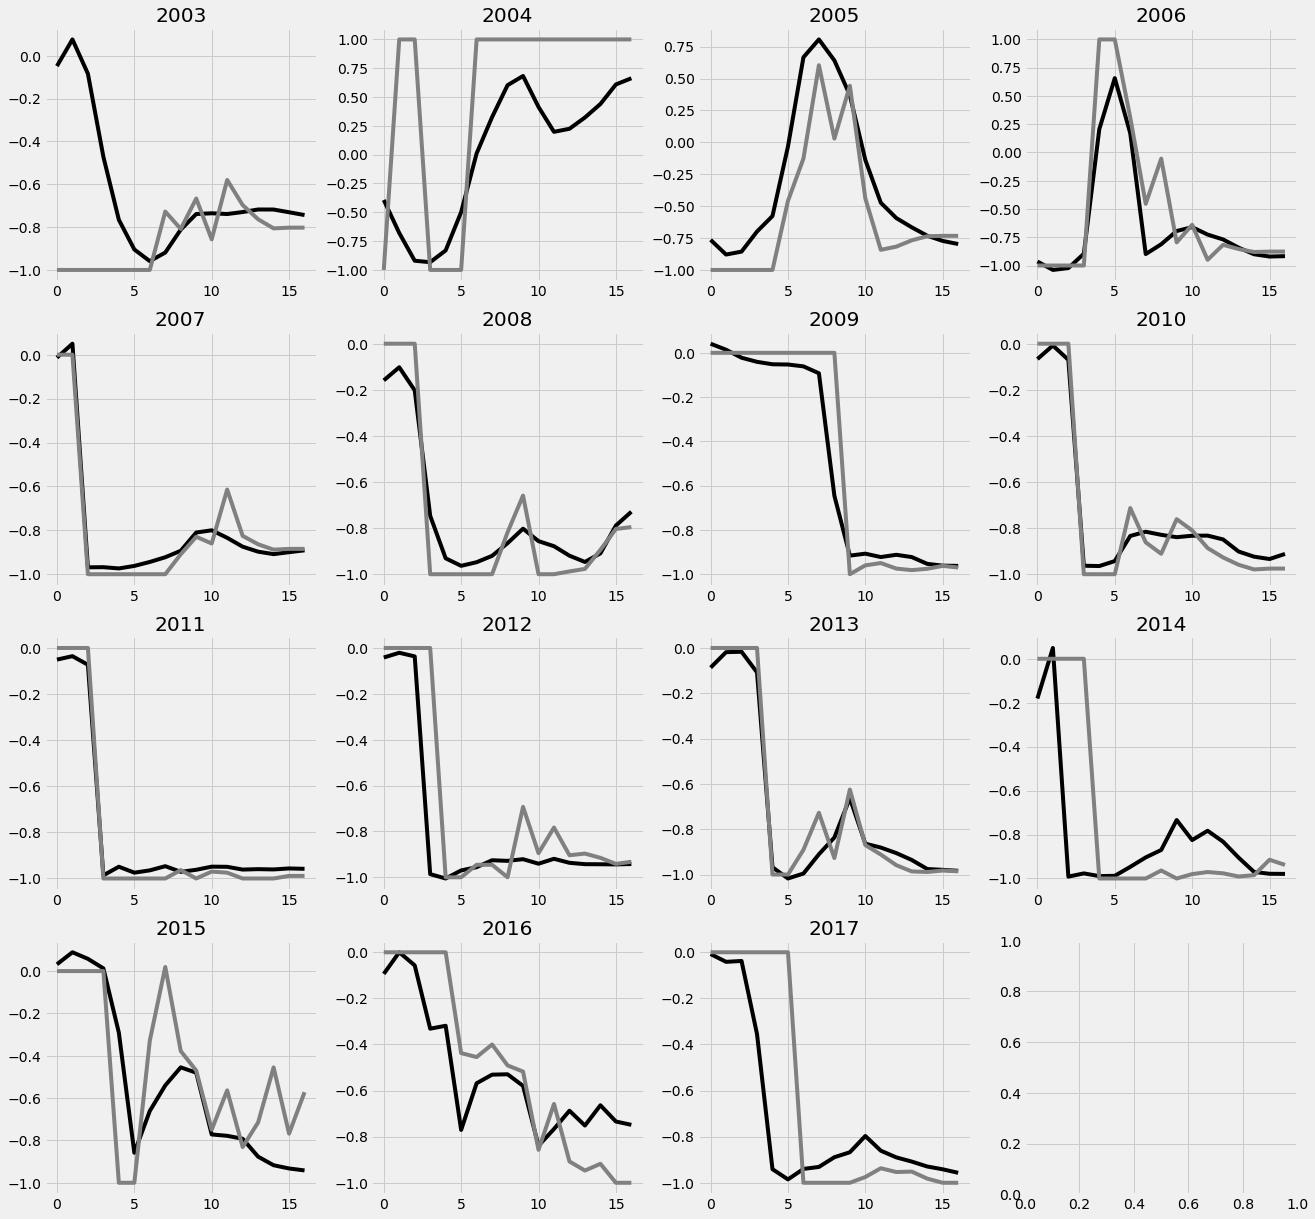

In [277]:
from sklearn.preprocessing import MinMaxScaler

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
Y_scale = np.nan_to_num(Y_scale)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.LSTM(32, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss='mse')


fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(20)
for j, year in enumerate(analysis_years):
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = X_scale[ind]
    train_Y = Y_scale[ind]
    
    test_X = X_scale[j].reshape(1, X_scale.shape[1], X_scale.shape[2])
    test_X[0][:, 3] = np.full(17, 0)
    test_Y = Y_scale[j].reshape(1, Y_scale.shape[1], Y_scale.shape[2])
    
    history = model.fit(train_X, train_Y, 
                    epochs=500, batch_size=16,)
    
    train_predictions = model.predict(train_X)

    # Train RMSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    print('###################')
    print(f'Train MSE for {year} is {train_mse}')
    print(f'Test MSE for {year} is {test_mse}')
    print('###################')
    
    jx = np.unravel_index(j, ax.shape)
    ax[jx].plot(test_predictions[0], color='black')
    ax[jx].plot(test_Y[0], color='gray')
    ax[jx].set_title(year)

#### Remove motiles on test

Epoch 1/500
14/14 [==============================] - 8s 592ms/sample - loss: 0.6404
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5852
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5503
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5180
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4490
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4383
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3912
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3476
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3265
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.2772
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3010
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3043
Epoch 13/50

Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1671
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1706
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1621
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1624
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1696
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1620
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1770
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1809
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1656
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1697
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1670
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1524
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1310
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1542
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1379
Epoch 202/500
14/14 [==============================] - 0s 1ms/sample - loss: 0.1312
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1430
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1444
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1534
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1459
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1444
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1369
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1023
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1101
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1063
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0927
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1092
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1113
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1086
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1107
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1010
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1080
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1013
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0976
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0928
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0945
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0866
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1142
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0944
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0857
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0922
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0875
Epoch 403/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0891
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0903
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0822
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0926
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0849
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0892
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0877
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0798
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0718
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0842
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0785
###################
Train MSE for 2003 is 0.04846938179014498
Test MSE for 2003 is 0.5467198371662317
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0994
Epoch 2/500
14/14 [=====================

Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0591
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0599
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0617
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0597
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0519
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0582
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0565
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0566
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0538
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0552
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0593
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0580
Ep

Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0495
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0542
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0577
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0537
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0478
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0514
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0498
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0534
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0499
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0504
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0480
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0462
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0471
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0455
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0571
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0509
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0463
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0458
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0548
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0446
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0456
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0477
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0468
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0514
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0463
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0431
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0548
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0416
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0419
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0435
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0472
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0423
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0411
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0743
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0751
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0661
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0854
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0754
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0774
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0782
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0759
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0702
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0864
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0693
Epoch 91/500
14/1

Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0628
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0605
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0632
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0606
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0616
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0618
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0730
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0625
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0578
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0563
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0637
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0508
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0508
Epoch 277/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0635
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0534
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0546
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0544
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0645
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0419
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0464
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0639
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0545
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0423
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0589
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0539
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0447
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0632
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0510
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0579
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0507
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0510
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0499
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0514
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0496
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0431
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0537
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0440
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0501
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0437
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0486
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0492
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0454
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0450
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0421
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0468
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoc

Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0397
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0401
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0355
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0452
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0366
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0435
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0369
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 366/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0383
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 368/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0344
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0271
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 469/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0303
Epoch 470/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0301
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0301
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0403
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0400
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0466
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 

Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 254/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0291
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 449/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0307
Epoch 450/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0278
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 456/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0303
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0430
Epoch 48/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0483
Epoch 49/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0449
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0395
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0401
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0426
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoc

Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 147/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 148/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0410
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0397
Epoch 153/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0315
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0418
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0349
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 245/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0369
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0360
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 343/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 344/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 441/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 442/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0386
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 38/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 39/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 40/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 41/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 42/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 43/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0355
Epoch 44/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0349
Epoch 45/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoc

Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0388
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 137/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 138/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 139/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 140/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 141/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 142/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 143/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0345
Epoch 144/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 235/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 236/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 237/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 238/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0350
Epoch 239/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 240/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 241/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 242/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 333/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 334/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0345
Epoch 335/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 336/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 337/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 338/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 339/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 340/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 431/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 432/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 433/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 434/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 435/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 436/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 437/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 438/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 28/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 29/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 30/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 31/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 32/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 33/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoch 34/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 35/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoc

Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0319
Epoch 127/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 128/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 129/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 130/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 131/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 132/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 133/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 134/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 225/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 226/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 227/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 228/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 229/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 230/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 231/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 232/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 323/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 324/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 325/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0312
Epoch 326/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 327/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 328/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 329/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 330/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 421/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 422/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 423/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 424/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 425/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 426/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 427/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0312
Epoch 428/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 17/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0416
Epoch 18/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 19/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0336
Epoch 20/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 21/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 22/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 23/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 24/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0380
Epoch 25/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0301
Epoc

Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 116/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoch 117/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 118/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 119/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 120/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 121/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 122/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 123/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 124/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 214/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 215/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 216/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 217/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 218/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 219/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 220/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 221/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 222/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 224/500
14/14 [==============================] - 0s 3ms/sample - loss:

Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 312/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 313/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 314/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 315/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 316/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 317/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 318/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 319/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 320/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 410/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 411/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 412/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0328
Epoch 413/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0273
Epoch 414/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 415/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 416/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 417/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 418/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 13/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 14/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 15/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 17/500
14/14 [=

Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 112/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 113/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 114/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 210/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 211/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 212/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 304/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0258
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 308/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 309/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 310/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 403/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 406/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 407/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 408/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
###################
Train MSE for 2012 is 0.004874071792845828
Test MSE for 2012 is 0.0487774701538026
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0332
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 6/500
14/14 [============================

Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.021

Epoch 192/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0212
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 195/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0250
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 486/500
14/14 [==============================] - 0s 1ms/sample - loss: 0.0161
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 494/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0272
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 95/500
14/1

Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 286/500
14/14 [==============================] - 0s 4ms/sample - loss: 0.0215
Epoch 287/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0212
Epoch 288/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0192
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0271
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0189
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0147
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoc

Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0151
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0174
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 469/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 470/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoc

Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0167
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0154
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0164
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0160
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0161
Epoch 

Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0144
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0166
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 344/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0161
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 442/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 449/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0246
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss:

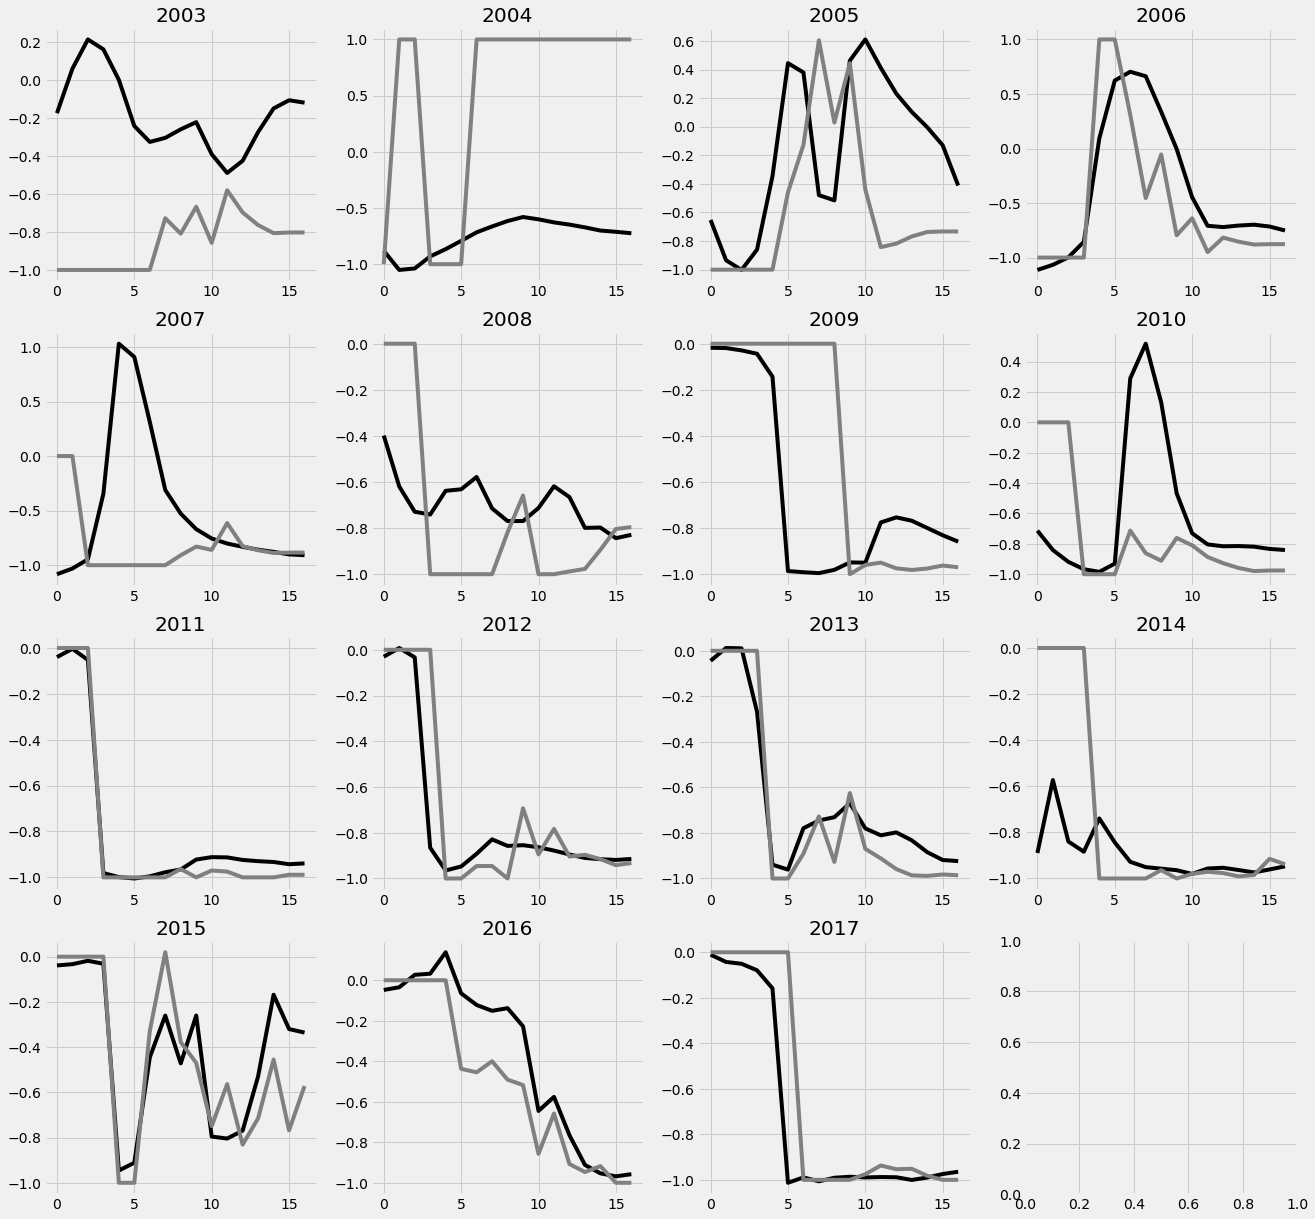

In [278]:
from sklearn.preprocessing import MinMaxScaler

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
Y_scale = np.nan_to_num(Y_scale)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.LSTM(32, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss='mse')


fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(20)
for j, year in enumerate(analysis_years):
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = X_scale[ind]
    train_Y = Y_scale[ind]
    
    test_X = X_scale[j].reshape(1, X_scale.shape[1], X_scale.shape[2])
    test_X[0][:, 0] = np.full(17, 0)
    test_Y = Y_scale[j].reshape(1, Y_scale.shape[1], Y_scale.shape[2])
    
    history = model.fit(train_X, train_Y, 
                    epochs=500, batch_size=16,)
    
    train_predictions = model.predict(train_X)

    # Train RMSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    print('###################')
    print(f'Train MSE for {year} is {train_mse}')
    print(f'Test MSE for {year} is {test_mse}')
    print('###################')
    
    jx = np.unravel_index(j, ax.shape)
    ax[jx].plot(test_predictions[0], color='black')
    ax[jx].plot(test_Y[0], color='gray')
    ax[jx].set_title(year)

#### Remove temperature on test

Epoch 1/500
14/14 [==============================] - 9s 633ms/sample - loss: 0.6983
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.6163
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5727
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5383
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4936
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4651
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4189
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3919
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3392
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3254
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3258
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.2966
Epoch 13/50

Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1786
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1829
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1741
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1711
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1760
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1797
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1849
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1740
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1836
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1868
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1701
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1434
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1572
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1490
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1511
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1495
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1465
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1393
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1542
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1596
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1460
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1498
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1324
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1078
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1219
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1125
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1262
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1300
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1087
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1247
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1134
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1211
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1326
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1028
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1090
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1037
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0916
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1041
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0950
Epoch 400/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0998
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0882
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0987
Epoch 403/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0893
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0946
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0843
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0838
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0941
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0940
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0866
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0886
Epoch 498/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0861
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0842
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0875
###################
Train MSE for 2003 is 0.05131474872671732
Test MSE for 2003 is 0.21561907767403443
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0746
Epoch 2/500
14/14 [====================

Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0564
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0578
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0596
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0674
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0595
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0599
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0622
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0599
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0635
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0608
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0634
Epoch 101/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0672
Ep

Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0503
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0503
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0583
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0546
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0544
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0588
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0535
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0588
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0531
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0604
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0636
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0529
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0525
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0515
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0433
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0469
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0532
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0505
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0488
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0561
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0501
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0502
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0486
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0442
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0540
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0453
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0498
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0471
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0484
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0464
Epoch 394/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0509
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0422
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0401
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0419
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0397
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0319
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0443
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0447
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0418
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0708
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0657
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0646
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0710
Epoch 83/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0649
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 85/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0720
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0687
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0602
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0656
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0754
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0558
Epoch 91/500
14/1

Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0660
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0594
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0680
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0549
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0610
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0573
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0625
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0616
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0629
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0574
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0660
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0622
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0472
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0498
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0491
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0486
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0524
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0553
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0628
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0556
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0425
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0553
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0486
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0496
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0444
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0427
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0519
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0472
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0464
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0369
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0461
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0437
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0409
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0463
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0389
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0371
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0442
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoc

Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0425
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0543
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 469/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 470/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0534
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0506
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0453
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0635
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0470
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0475
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0538
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0447
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0516
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0404
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0439
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0393
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 

Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0301
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0360
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 48/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 49/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0332
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoc

Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 147/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 148/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 245/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 343/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 344/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 441/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 442/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 38/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 39/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 40/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 41/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 42/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 43/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 44/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 45/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoc

Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 137/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 138/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 139/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 140/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 141/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 142/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 143/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 144/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 235/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 236/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 237/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 238/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 239/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 240/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 241/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 242/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 333/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 334/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 335/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 336/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 337/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 338/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 339/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 340/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 431/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 432/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 433/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 434/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 435/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 436/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 437/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 438/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 28/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 29/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 30/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 31/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 32/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 33/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 34/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 35/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 37/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0272
Epoc

Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 127/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 128/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 129/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 130/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 131/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 132/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 133/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 134/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 225/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 226/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 227/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 228/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 229/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0280
Epoch 230/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 231/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 232/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0295
Epoch 323/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 324/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 325/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 326/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 327/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 328/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 329/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 330/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 421/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 422/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 423/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 424/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 425/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 426/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 427/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 428/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0166
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 17/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 18/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 19/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 20/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 21/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 22/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 23/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 24/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 25/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoc

Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 116/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 117/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 118/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 119/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 120/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 121/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 122/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 123/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0271
Epoch 124/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0189
Epoch 214/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 215/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 216/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 217/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 218/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 219/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 220/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 221/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 222/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 312/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 313/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 314/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 315/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 316/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 317/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 318/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 319/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 320/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 410/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 411/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 412/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 413/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 414/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 415/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 416/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 417/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 418/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 13/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 14/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0260
Epoch 15/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0237
Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 17/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0210
Epoch 18

Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 112/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 113/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0168
Epoch 114/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 116/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 210/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 211/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 212/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 214/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0166
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 308/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 309/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 310/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 312/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0295
Epoch 403/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 406/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 407/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 408/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 410/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
###################
Train MSE for 2012 is 0.001579102871268095
Test MSE for 2012 is 0.01876127471012354
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 5/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0254
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 7/500
14/14 [=============================

Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.02

Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0158
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0151
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 494/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0160
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0189
Epoch 496/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0193
Epoch 497/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0182
Epoch 498/500
14/14 [==============================] - 0s 3ms/sample - loss:

14/14 [==============================] - 0s 4ms/sample - loss: 0.0233
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0163
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0158
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 96/500
14/1

Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 184/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0238
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0149
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 189/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0219
Epoch 190/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0179
Epoch 191/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0267
Epoch 192/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0190
Epoch 193/500
14/14 [==============================] - 0s 3ms/sample - loss:

Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0153
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0145
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0150
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0189
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0161
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0156
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoc

Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0160
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0151
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0166
Epoch 179/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0161
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0145
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0165
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0160
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0145
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 276/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0190
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0142
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0158
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 469/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 470/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0139
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0145
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoc

Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0167
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0189
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0163
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 455/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0192
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0168
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0144
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0150
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 159/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0171
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 

Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0149
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0174
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0142
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0159
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0137
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss:

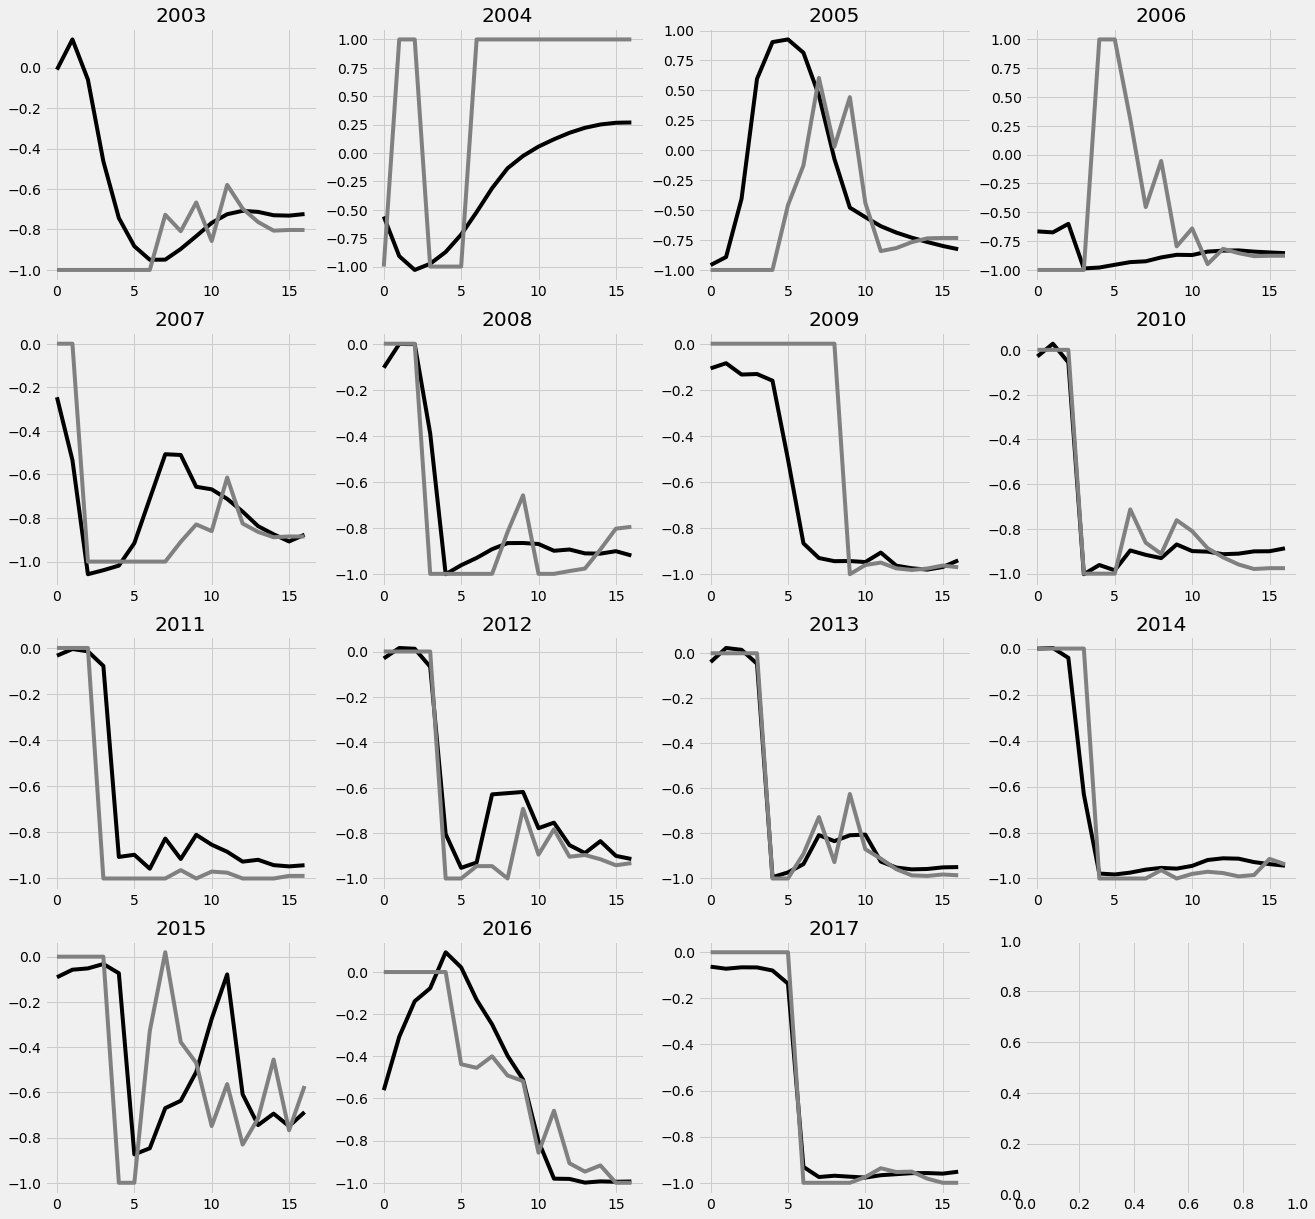

In [279]:
from sklearn.preprocessing import MinMaxScaler

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
Y_scale = np.nan_to_num(Y_scale)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.LSTM(32, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss='mse')


fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(20)
for j, year in enumerate(analysis_years):
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = X_scale[ind]
    train_Y = Y_scale[ind]
    
    test_X = X_scale[j].reshape(1, X_scale.shape[1], X_scale.shape[2])
    test_X[0][:, 1] = np.full(17, 0)
    test_Y = Y_scale[j].reshape(1, Y_scale.shape[1], Y_scale.shape[2])
    
    history = model.fit(train_X, train_Y, 
                    epochs=500, batch_size=16,)
    
    train_predictions = model.predict(train_X)

    # Train RMSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    print('###################')
    print(f'Train MSE for {year} is {train_mse}')
    print(f'Test MSE for {year} is {test_mse}')
    print('###################')
    
    jx = np.unravel_index(j, ax.shape)
    ax[jx].plot(test_predictions[0], color='black')
    ax[jx].plot(test_Y[0], color='gray')
    ax[jx].set_title(year)

#### Remove salinity on test

Epoch 1/500
14/14 [==============================] - 10s 681ms/sample - loss: 0.6818
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.6353
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5961
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5463
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5190
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4786
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4480
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4074
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3992
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3404
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3064
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.2831
Epoch 13/5

Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1738
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1756
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1639
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1798
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1768
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1667
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1648
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1766
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1706
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1886
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1766
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1470
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1379
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1586
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1346
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1538
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1519
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1429
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1351
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1518
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1347
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1399
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1197
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1147
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1228
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1140
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1052
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1097
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1060
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1232
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1199
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1062
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1095
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0946
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1028
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1092
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0951
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0893
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0990
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1086
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0958
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1254
Epoch 403/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0883
Epoch 404/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0911
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0814
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0902
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0827
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0843
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0949
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0871
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0898
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0849
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0873
###################
Train MSE for 2003 is 0.05237123087487512
Test MSE for 2003 is 0.13860084502328573
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0656
Epoch 2/500
14/14 [====================

Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0639
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0652
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0605
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0640
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0692
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0646
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0675
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0558
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0614
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0643
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0590
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0710
Ep

Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0646
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0505
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0594
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0589
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0550
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0564
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0581
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0569
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0560
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0556
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0575
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0582
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0536
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0522
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0490
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0521
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0533
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0510
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0488
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0470
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0522
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0506
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0470
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0490
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0484
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0489
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0518
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0493
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0566
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0443
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0537
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0556
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0422
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0459
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0461
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0421
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0457
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0416
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0495
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0483
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0458
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0678
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0717
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0642
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0780
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0610
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0645
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0667
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0615
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0532
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0610
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0642
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0644
Epoc

Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0581
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0618
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0578
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0583
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0647
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0603
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0555
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0657
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0594
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0645
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0566
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0641
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0586
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0601
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0518
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0513
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0591
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0568
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0573
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0558
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0588
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0552
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0493
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0633
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0546
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0509
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0521
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0533
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0595
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0504
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0559
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0471
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0577
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0442
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0445
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0574
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0557
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0473
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0516
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0539
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0519
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0456
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0522
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0545
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0481
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0464
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0452
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0491
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0437
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0435
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0483
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0478
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0485
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0499
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0443
Epoc

Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0554
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0427
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0535
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0456
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0427
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0511
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0431
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0441
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0419
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0404
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0440
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0444
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 369/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0374
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0405
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0425
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0442
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0441
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 469/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0393
Epoch 470/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0435
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0458
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0392
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0432
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0452
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0451
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0416
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0417
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0458
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0424
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0410
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0416
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 

Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0511
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0412
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0409
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0532
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 358/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0400
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0350
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0395
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0380
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0416
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0429
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0392
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0360
Epoch 48/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 49/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0484
Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0325
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0405
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 146/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0308
Epoch 147/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0344
Epoch 148/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0329
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 

Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 245/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0418
Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0355
Epoch 343/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 344/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0293
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 441/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 442/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0350
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 38/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 39/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 40/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 41/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 42/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 43/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 44/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 45/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoc

Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 137/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 138/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0360
Epoch 139/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 140/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 141/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 142/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 143/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 144/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 235/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 236/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 237/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 238/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoch 239/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 240/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 241/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 242/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 333/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 334/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 335/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 336/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0332
Epoch 337/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 338/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 339/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 340/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 431/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 432/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 433/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 434/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 435/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 436/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 437/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 438/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 28/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 29/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 30/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0430
Epoch 31/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0433
Epoch 32/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0547
Epoch 33/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 34/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0425
Epoch 35/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0439
Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0428
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0418
Epoc

Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 127/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0325
Epoch 128/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0371
Epoch 129/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 130/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 131/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 132/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 133/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 134/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0355
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 225/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 226/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 227/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 228/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 229/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 230/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 231/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 232/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 323/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 324/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 325/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 326/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 327/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 328/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0311
Epoch 329/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 330/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0423
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 421/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 422/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 423/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 424/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 425/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 426/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 427/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 428/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 17/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0409
Epoch 18/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 19/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 20/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 21/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0325
Epoch 22/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 23/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 24/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 25/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoc

Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0312
Epoch 116/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 117/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 118/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0295
Epoch 119/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 120/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 121/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 122/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 123/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 124/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 214/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 215/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 216/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 217/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 218/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoch 219/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 220/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 221/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 222/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 312/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 313/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 314/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 315/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 316/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 317/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 318/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 319/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 320/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0301
Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 410/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 411/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 412/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 413/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0271
Epoch 414/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 415/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 416/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0301
Epoch 417/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 418/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 13/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 14/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 15/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 17/500
14/14 [=

Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 112/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 113/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 114/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 210/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 211/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 212/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 308/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 309/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 310/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 398/500
14/14 [==============================] - 0s 4ms/sample - loss: 0.0216
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 403/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0296
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0312
Epoch 406/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 407/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 408/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
###################
Train MSE for 2012 is 0.0046649751242221335
Test MSE for 2012 is 0.023225130855743157
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0312
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 6/500
14/14 [=========================

Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.030

Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 391/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0224
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 95/500
14/1

Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0325
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0156
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0159
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoc

Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 374/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0172
Epoch 375/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0251
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 469/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0224
Epoch 470/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0211
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 473/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0191
Epoch 474/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0189
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoc

Epoch 159/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0224
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 170/500
14/14 [==============================] - 0s 3ms/sample - loss:

Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0166
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 355/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0312
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0161
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0271
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0189
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0174
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 

Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0150
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0139
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 255/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0196
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0148
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 344/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0202
Epoch 345/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0158
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 347/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0189
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 349/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0219
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0163
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 442/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0143
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss:

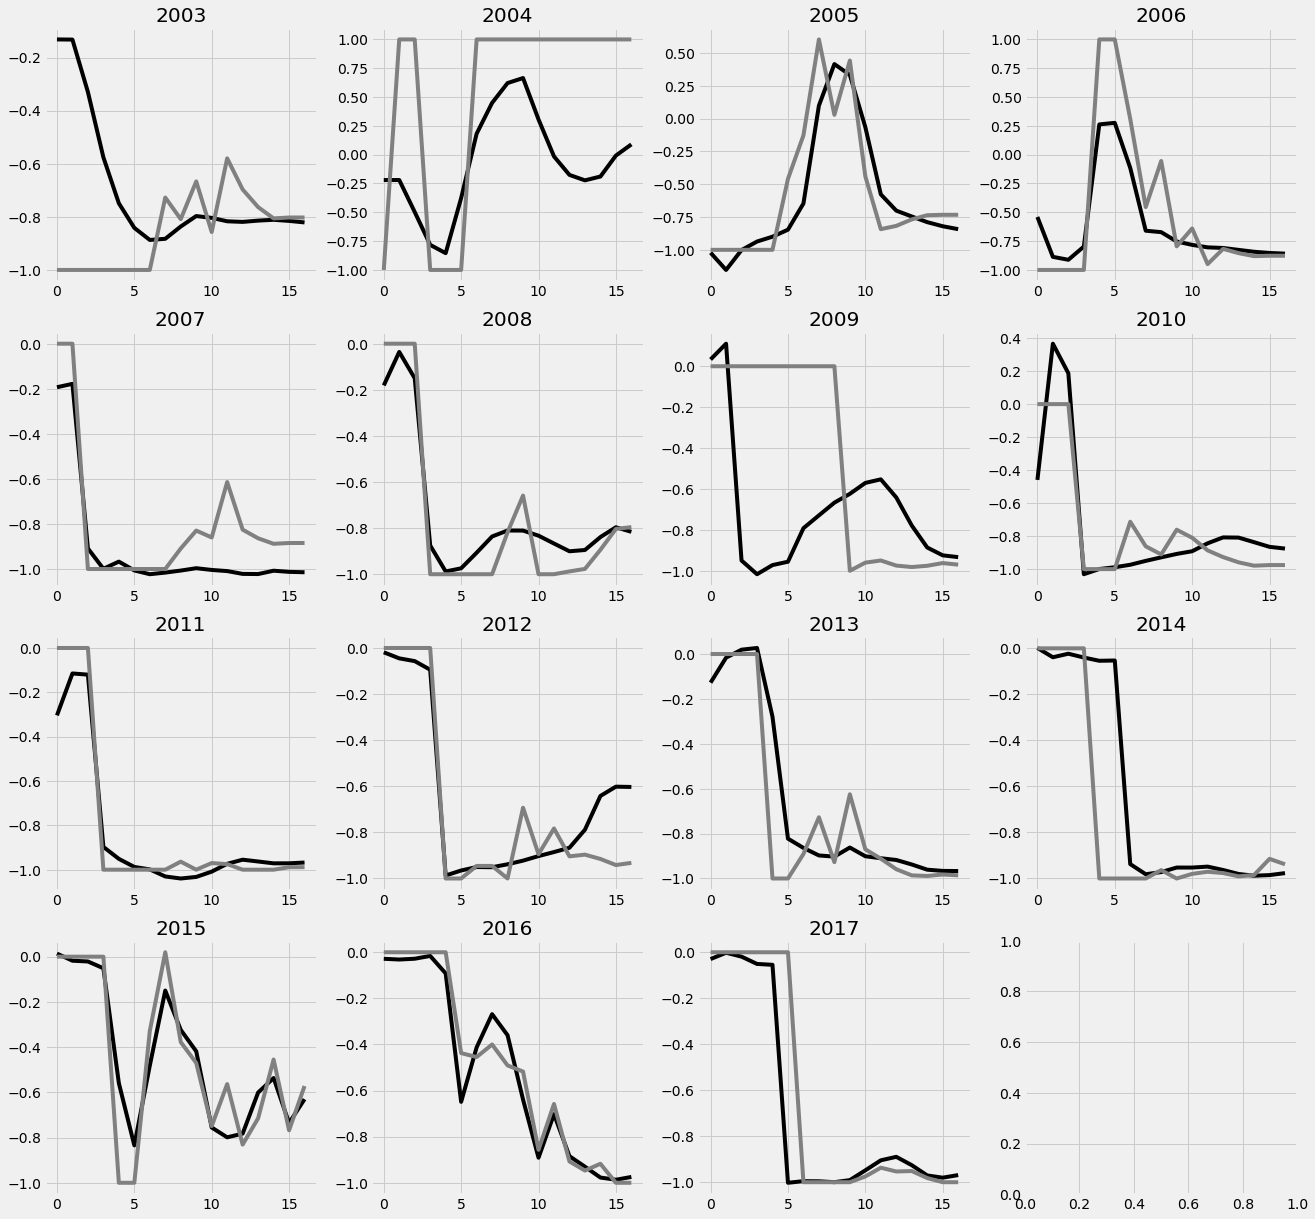

In [280]:
from sklearn.preprocessing import MinMaxScaler

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
Y_scale = np.nan_to_num(Y_scale)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.LSTM(32, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss='mse')


fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(20)
for j, year in enumerate(analysis_years):
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = X_scale[ind]
    train_Y = Y_scale[ind]
    
    test_X = X_scale[j].reshape(1, X_scale.shape[1], X_scale.shape[2])
    test_X[0][:, 2] = np.full(17, 0)
    test_Y = Y_scale[j].reshape(1, Y_scale.shape[1], Y_scale.shape[2])
    
    history = model.fit(train_X, train_Y, 
                    epochs=500, batch_size=16,)
    
    train_predictions = model.predict(train_X)

    # Train RMSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    print('###################')
    print(f'Train MSE for {year} is {train_mse}')
    print(f'Test MSE for {year} is {test_mse}')
    print('###################')
    
    jx = np.unravel_index(j, ax.shape)
    ax[jx].plot(test_predictions[0], color='black')
    ax[jx].plot(test_Y[0], color='gray')
    ax[jx].set_title(year)

#### Remove all but temperature on test

Epoch 1/500
14/14 [==============================] - 10s 697ms/sample - loss: 0.6261
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5962
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5650
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5323
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4770
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4476
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4130
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3713
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3407
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3011
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3154
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3014
Epoch 13/5

Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1747
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1559
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1708
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1705
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1824
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1696
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1656
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1632
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1785
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1713
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1651
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1511
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1384
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1605
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1347
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1383
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1459
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1476
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1417
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1439
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1407
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1469
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1272
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1099
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1110
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1111
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1030
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1074
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1144
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1282
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1197
Epoch 305/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.1147
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1052
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0979
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0962
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1053
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0969
Epoch 398/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0952
Epoch 399/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.1007
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0993
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0968
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0901
Epoch 403/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.1019
Epoch 404/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.1125
Epoch 405/500
14/14 [==============================] - 0s 3ms/sample - loss:

Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0843
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0810
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0804
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0808
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0829
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1058
Epoch 498/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0770
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0857
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1009
###################
Train MSE for 2003 is 0.05726122070782169
Test MSE for 2003 is 0.2731588487852936
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0851
Epoch 2/500
14/14 [=====================

Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0640
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0643
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0585
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0602
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0659
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0643
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0558
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0582
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0584
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0616
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0525
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0575
Ep

Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0511
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0523
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0458
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0532
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0490
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0451
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0598
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0564
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0545
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0573
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0544
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0481
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0485
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0541
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0521
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0477
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0443
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0437
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0523
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0443
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0441
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0513
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0507
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0469
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0478
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0423
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0495
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0405
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0478
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0419
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0502
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0484
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0445
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0393
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0466
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0442
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0719
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0751
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0717
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0729
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0768
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0734
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0841
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0794
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0786
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0749
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0786
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0847
Epoch 91/500
14/1

Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0729
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0663
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0720
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0682
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0754
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0767
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0747
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0650
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0796
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0683
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0661
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0733
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0681
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0664
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0636
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0703
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0705
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0676
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0693
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0708
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0608
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0645
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0644
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0668
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0653
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0823
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0699
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0654
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0659
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0721
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0691
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0702
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0569
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0648
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0606
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0596
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0589
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0677
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0491
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0626
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0637
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0647
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0616
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0646
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0575
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0641
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0698
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0629
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0686
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0614
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0603
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0628
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0575
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0647
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0620
Epoc

Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0619
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0592
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0599
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0584
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0592
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0625
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0554
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0620
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0532
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0585
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0643
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0599
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0650
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0557
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0703
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0514
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0586
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0705
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0608
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0638
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0525
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0574
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0589
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0581
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0559
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0544
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0566
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0551
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0543
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0547
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0515
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0590
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0548
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0527
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0537
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0589
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0529
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0550
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0524
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0620
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0541
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0545
Epoch 469/500
14/14 [==============================] - 0s 4ms/sample - loss: 0.0587
Epoch 470/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0531
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0553
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0568
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0537
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0592
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0577
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0555
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0543
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0629
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0610
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0554
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0619
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0578
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0551
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0506
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0615
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0599
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0497
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0505
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0580
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0621
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0586
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0509
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0523
Epoch 

Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0560
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0539
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0522
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0553
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0467
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0545
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0503
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0534
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0506
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0490
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0529
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0481
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0530
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0521
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0495
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0509
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0469
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0469
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0492
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0554
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0491
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0462
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0505
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0488
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0506
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0465
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0561
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0468
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0528
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0511
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0503
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0505
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0550
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0611
Epoch 48/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0534
Epoch 49/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0529
Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0639
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0653
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0519
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0645
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0454
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0636
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0535
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0588
Epoc

Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0435
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0473
Epoch 147/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0554
Epoch 148/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0443
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0452
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0504
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0417
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0452
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0472
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0523
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0470
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0623
Epoch 245/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0405
Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0546
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0495
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0468
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0429
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0486
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0445
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0576
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0495
Epoch 343/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 344/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0483
Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0470
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0512
Epoch 347/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0412
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0495
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0437
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0424
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0386
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0452
Epoch 441/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0525
Epoch 442/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0531
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0416
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0524
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0411
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0511
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0516
Epoch 38/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0624
Epoch 39/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 40/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0504
Epoch 41/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0510
Epoch 42/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0534
Epoch 43/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 44/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0425
Epoch 45/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0535
Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0484
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoc

Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0464
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0507
Epoch 137/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0463
Epoch 138/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0474
Epoch 139/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 140/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0459
Epoch 141/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0425
Epoch 142/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0451
Epoch 143/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 144/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0491
Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0465
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0405
Epoch 235/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 236/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0400
Epoch 237/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0435
Epoch 238/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0412
Epoch 239/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0469
Epoch 240/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0591
Epoch 241/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0486
Epoch 242/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0424
Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0472
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0480
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0469
Epoch 333/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 334/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 335/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 336/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0437
Epoch 337/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0471
Epoch 338/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 339/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0430
Epoch 340/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0437
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0512
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0490
Epoch 431/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0502
Epoch 432/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0487
Epoch 433/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0552
Epoch 434/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 435/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 436/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 437/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 438/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0441
Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0486
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0549
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0515
Epoch 28/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0446
Epoch 29/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0521
Epoch 30/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0452
Epoch 31/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0510
Epoch 32/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0613
Epoch 33/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0464
Epoch 34/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0477
Epoch 35/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0513
Epoc

Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 127/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 128/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 129/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0393
Epoch 130/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 131/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 132/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 133/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 134/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0397
Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0430
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 225/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 226/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 227/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0445
Epoch 228/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 229/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0386
Epoch 230/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 231/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 232/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0526
Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0371
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 323/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0355
Epoch 324/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 325/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 326/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 327/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 328/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 329/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0388
Epoch 330/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0351
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 421/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 422/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0350
Epoch 423/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 424/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 425/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0276
Epoch 426/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 427/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 428/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0395
Epoch 17/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0383
Epoch 18/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0429
Epoch 19/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 20/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 21/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 22/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 23/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0392
Epoch 24/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 25/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoc

Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 116/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 117/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0423
Epoch 118/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 119/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 120/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 121/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0409
Epoch 122/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0386
Epoch 123/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 124/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 214/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 215/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 216/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 217/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 218/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 219/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 220/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0349
Epoch 221/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 222/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 312/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 313/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 314/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0445
Epoch 315/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 316/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 317/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoch 318/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0293
Epoch 319/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 320/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 410/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 411/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 412/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 413/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 414/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 415/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 416/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 417/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 418/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 13/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 14/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 15/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0371
Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 17/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 18

Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0319
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 112/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 113/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 114/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 116/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0389
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 210/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 211/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 212/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 214/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0312
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 308/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 309/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 310/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 312/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 403/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 406/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0269
Epoch 407/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 408/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 410/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
###################
Train MSE for 2012 is 0.007028127802571795
Test MSE for 2012 is 0.09173165229721034
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0459
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0295
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0366
Epoch 7/500
14/14 [=============================

Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.03

Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0295
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 296/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0364
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0349
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0301
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0332
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 497/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0308
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0431
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0476
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0456
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 96/500
14/1

Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0501
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0574
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0360
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0462
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0508
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0369
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0457
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0350
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0405
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 287/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0334
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0389
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0295
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0388
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0397
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 477/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0495
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0355
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0350
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0380
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0483
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 85/500
14/1

14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0319
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0351
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 

Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0474
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0332
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0411
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0366
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0312
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 375/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0327
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0380
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 469/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 470/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0411
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0351
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0429
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0455
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0404
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0469
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0411
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0412
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0484
Epoc

Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0351
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0476
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0416
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0392
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0421
Epoch 360/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0302
Epoch 361/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0332
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0360
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0369
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0332
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0533
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0401
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0445
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0471
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0447
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0412
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0403
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0457
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0426
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0371
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 

Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0491
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0419
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0444
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 355/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0326
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0295
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0409
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss:

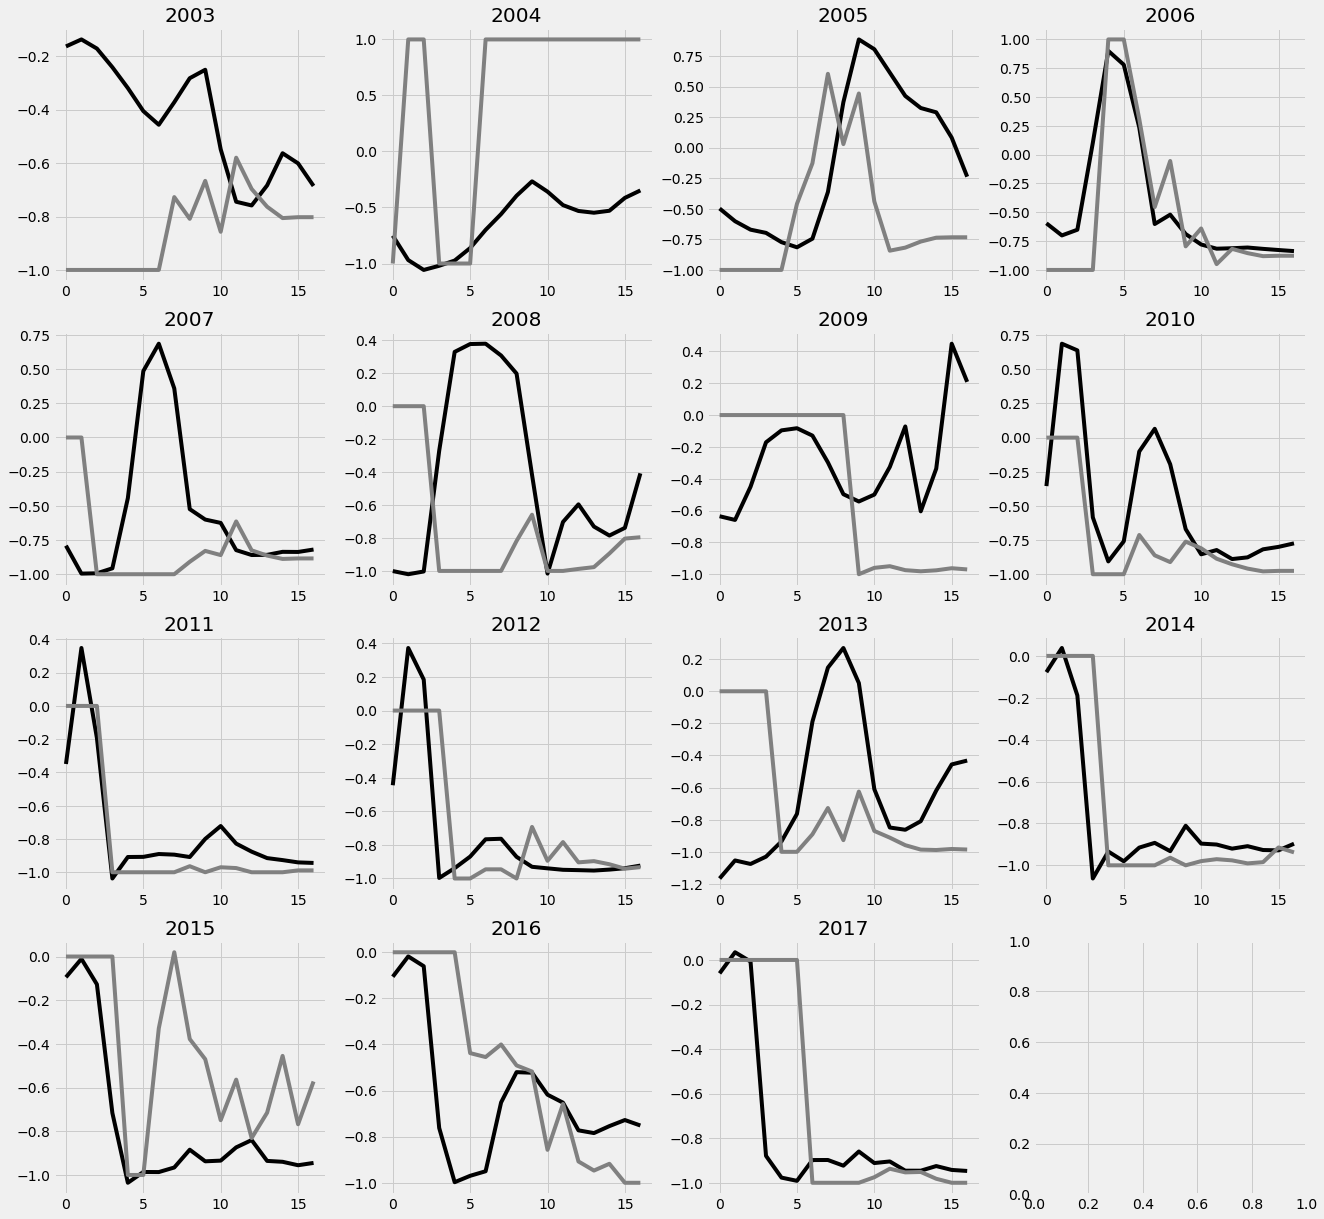

In [281]:
from sklearn.preprocessing import MinMaxScaler

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
Y_scale = np.nan_to_num(Y_scale)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.LSTM(32, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss='mse')


fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(20)
for j, year in enumerate(analysis_years):
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = X_scale[ind]
    train_Y = Y_scale[ind]
    
    test_X = X_scale[j].reshape(1, X_scale.shape[1], X_scale.shape[2])
    test_X[0][:, 0] = np.full(17, 0)
    test_X[0][:, 2] = np.full(17, 0)
    test_X[0][:, 3] = np.full(17, 0)
    test_Y = Y_scale[j].reshape(1, Y_scale.shape[1], Y_scale.shape[2])
    
    history = model.fit(train_X, train_Y, 
                    epochs=500, batch_size=16,)
    
    train_predictions = model.predict(train_X)

    # Train RMSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    print('###################')
    print(f'Train MSE for {year} is {train_mse}')
    print(f'Test MSE for {year} is {test_mse}')
    print('###################')
    
    jx = np.unravel_index(j, ax.shape)
    ax[jx].plot(test_predictions[0], color='black')
    ax[jx].plot(test_Y[0], color='gray')
    ax[jx].set_title(year)

#### Only temperature and only the first two months of temperature data

Epoch 1/500
14/14 [==============================] - 10s 746ms/sample - loss: 0.6624
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.6191
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5857
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5601
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5302
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5049
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4584
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4158
Epoch 9/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.3880
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3718
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3358
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.2947
Epoch 13/5

Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1679
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1784
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1759
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1847
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1807
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1760
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1781
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1615
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1645
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1736
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1674
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1415
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1462
Epoch 200/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.1461
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1535
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1478
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1565
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1460
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1566
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1561
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1581
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1467
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1255
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1178
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1241
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1331
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1328
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1190
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1221
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1279
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1166
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1297
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1110
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0957
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1092
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1047
Epoch 397/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.1052
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1024
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1044
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1047
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0877
Epoch 402/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.1017
Epoch 403/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1031
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1033
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0953
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0872
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0893
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0862
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0886
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0841
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0913
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0887
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0936
###################
Train MSE for 2003 is 0.052147317062014746
Test MSE for 2003 is 0.24699039985697085
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0721
Epoch 2/500
14/14 [===================

Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0569
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0594
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0562
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0616
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0705
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0675
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0619
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0722
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0526
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0699
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0628
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0620
Ep

Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0563
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0563
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0668
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0593
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0458
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0499
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0612
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0600
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0594
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0505
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0508
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0537
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0511
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0556
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0545
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0508
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0609
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0437
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0519
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0435
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0490
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0492
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0499
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0440
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0468
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0517
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0429
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0456
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0456
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0472
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0410
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0511
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0486
Epoch 491/500
14/14 [==============================] - 0s 4ms/sample - loss: 0.0497
Epoch 492/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0460
Epoch 493/500
14/14 [==============================] - 0s 3ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0817
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0738
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0753
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0855
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0828
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0765
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0815
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0737
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0692
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0762
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0770
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0824
Epoch 91/500
14/1

Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0765
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0744
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0707
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0738
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0731
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0757
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0746
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0742
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0689
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0720
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0726
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0709
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0748
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0648
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0670
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0655
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0636
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0716
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0661
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0678
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0759
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0872
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0639
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0551
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0672
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0612
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0529
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0591
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0564
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0549
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0543
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0556
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0573
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0553
Epoch 472/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0555
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0515
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0523
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0568
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0564
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0439
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0585
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0517
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0488
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0580
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0543
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0628
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0545
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0601
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0571
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0577
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0647
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0597
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0523
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0597
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0531
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0573
Epoc

Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0639
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0528
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0533
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0588
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0450
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0466
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0485
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0580
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0530
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0516
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0469
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0476
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0491
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0582
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0563
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0559
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0542
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0507
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0454
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0550
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0430
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0521
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0454
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0497
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0535
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0428
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0518
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0524
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0517
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0478
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0388
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0485
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0556
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0461
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0480
Epoch 469/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0526
Epoch 470/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0478
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0472
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0419
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0485
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0465
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0412
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0449
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0536
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0446
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0517
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0423
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0477
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0446
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0403
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0527
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0468
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0440
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0450
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0481
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0432
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0433
Epoch 

Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0449
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0530
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0484
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0444
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0430
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0427
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0504
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0539
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0401
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0483
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0441
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0520
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0417
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0429
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0393
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0416
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0405
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0462
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0533
Epoch 48/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0487
Epoch 49/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0492
Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0600
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0485
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0517
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0439
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0445
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0467
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0520
Epoc

Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0484
Epoch 147/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 148/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0508
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0409
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0411
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0507
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0386
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0400
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 245/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0429
Epoch 249/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0386
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0430
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 253/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0380
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0458
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0422
Epoch 343/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 344/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0409
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0475
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0431
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0429
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0428
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 441/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0521
Epoch 442/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0447
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0405
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0418
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0463
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0485
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0409
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0392
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0636
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0525
Epoch 38/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 39/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0564
Epoch 40/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0467
Epoch 41/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0516
Epoch 42/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0494
Epoch 43/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0511
Epoch 44/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0504
Epoch 45/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0517
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0492
Epoc

Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0500
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0421
Epoch 137/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 138/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0449
Epoch 139/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0403
Epoch 140/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0436
Epoch 141/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0487
Epoch 142/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 143/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0466
Epoch 144/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0600
Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0546
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0388
Epoch 235/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0427
Epoch 236/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 237/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0536
Epoch 238/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 239/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0513
Epoch 240/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0444
Epoch 241/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 242/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0441
Epoch 333/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 334/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0431
Epoch 335/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0508
Epoch 336/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 337/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 338/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 339/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 340/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0526
Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0560
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0490
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0366
Epoch 431/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 432/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 433/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0421
Epoch 434/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0409
Epoch 435/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 436/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0360
Epoch 437/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 438/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0452
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0426
Epoch 28/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0481
Epoch 29/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 30/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 31/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0442
Epoch 32/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0464
Epoch 33/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0461
Epoch 34/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0471
Epoch 35/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0479
Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0401
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0446
Epoc

Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0425
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0441
Epoch 127/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0388
Epoch 128/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 129/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 130/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0412
Epoch 131/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 132/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0425
Epoch 133/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0371
Epoch 134/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0428
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0424
Epoch 225/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 226/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 227/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 228/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 229/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 230/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 231/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 232/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0412
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0383
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 323/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 324/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0389
Epoch 325/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 326/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 327/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 328/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 329/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 330/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0480
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0345
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 421/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0319
Epoch 422/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 423/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 424/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 425/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 426/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 427/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 428/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0366
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0350
Epoch 17/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0542
Epoch 18/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0469
Epoch 19/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0405
Epoch 20/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 21/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 22/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 23/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0419
Epoch 24/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0412
Epoch 25/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0449
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0446
Epoc

Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 116/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 117/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0428
Epoch 118/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 119/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 120/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 121/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0386
Epoch 122/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 123/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 124/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0386
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0401
Epoch 214/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 215/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 216/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 217/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 218/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 219/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 220/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 221/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 222/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0355
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 312/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 313/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 314/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0432
Epoch 315/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 316/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 317/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 318/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 319/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 320/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0389
Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 410/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 411/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 412/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0355
Epoch 413/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0449
Epoch 414/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 415/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 416/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0430
Epoch 417/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0325
Epoch 418/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0475
Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 13/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 14/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 15/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 17/500
14/14 [=

Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0345
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 112/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 113/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 114/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0295
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 210/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 211/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 212/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0332
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 308/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 309/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 310/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0380
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 403/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 406/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 407/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0393
Epoch 408/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
###################
Train MSE for 2012 is 0.010915663627125193
Test MSE for 2012 is 0.0843573368609262
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0319
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0371
Epoch 6/500
14/14 [============================

Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0376
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0400
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0293
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.034

Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0393
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0369
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0291
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0341
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0554
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0463
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0420
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0422
Epoch 95/500
14/1

Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0388
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0317
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0369
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0403
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0322
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0411
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0360
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0404
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0433
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0312
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 480/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0464
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0411
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 84/500
14/1

14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0357
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0293
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0466
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0320
Epoch 

Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0369
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0350
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0417
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0351
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0293
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0319
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0450
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0439
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 465/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0351
Epoch 466/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 467/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0346
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 469/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 470/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0290
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0366
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 474/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0499
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0496
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0491
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0472
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0481
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0352
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0421
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0476
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0453
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0506
Epoc

Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0421
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0370
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0350
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0433
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0438
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0496
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0495
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0441
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0411
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0390
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0397
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0372
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0423
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0469
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0301
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0325
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0293
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0442
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0498
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0617
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0455
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0465
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0448
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0600
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0392
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0418
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0472
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0442
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0396
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0427
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0449
Epoch 

Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0510
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0360
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0358
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0416
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0395
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0333
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 344/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0332
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0393
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0380
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0410
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 442/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0309
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0335
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0354
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0327
Epoch 448/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0344
Epoch 449/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0375
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0462
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0405
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss:

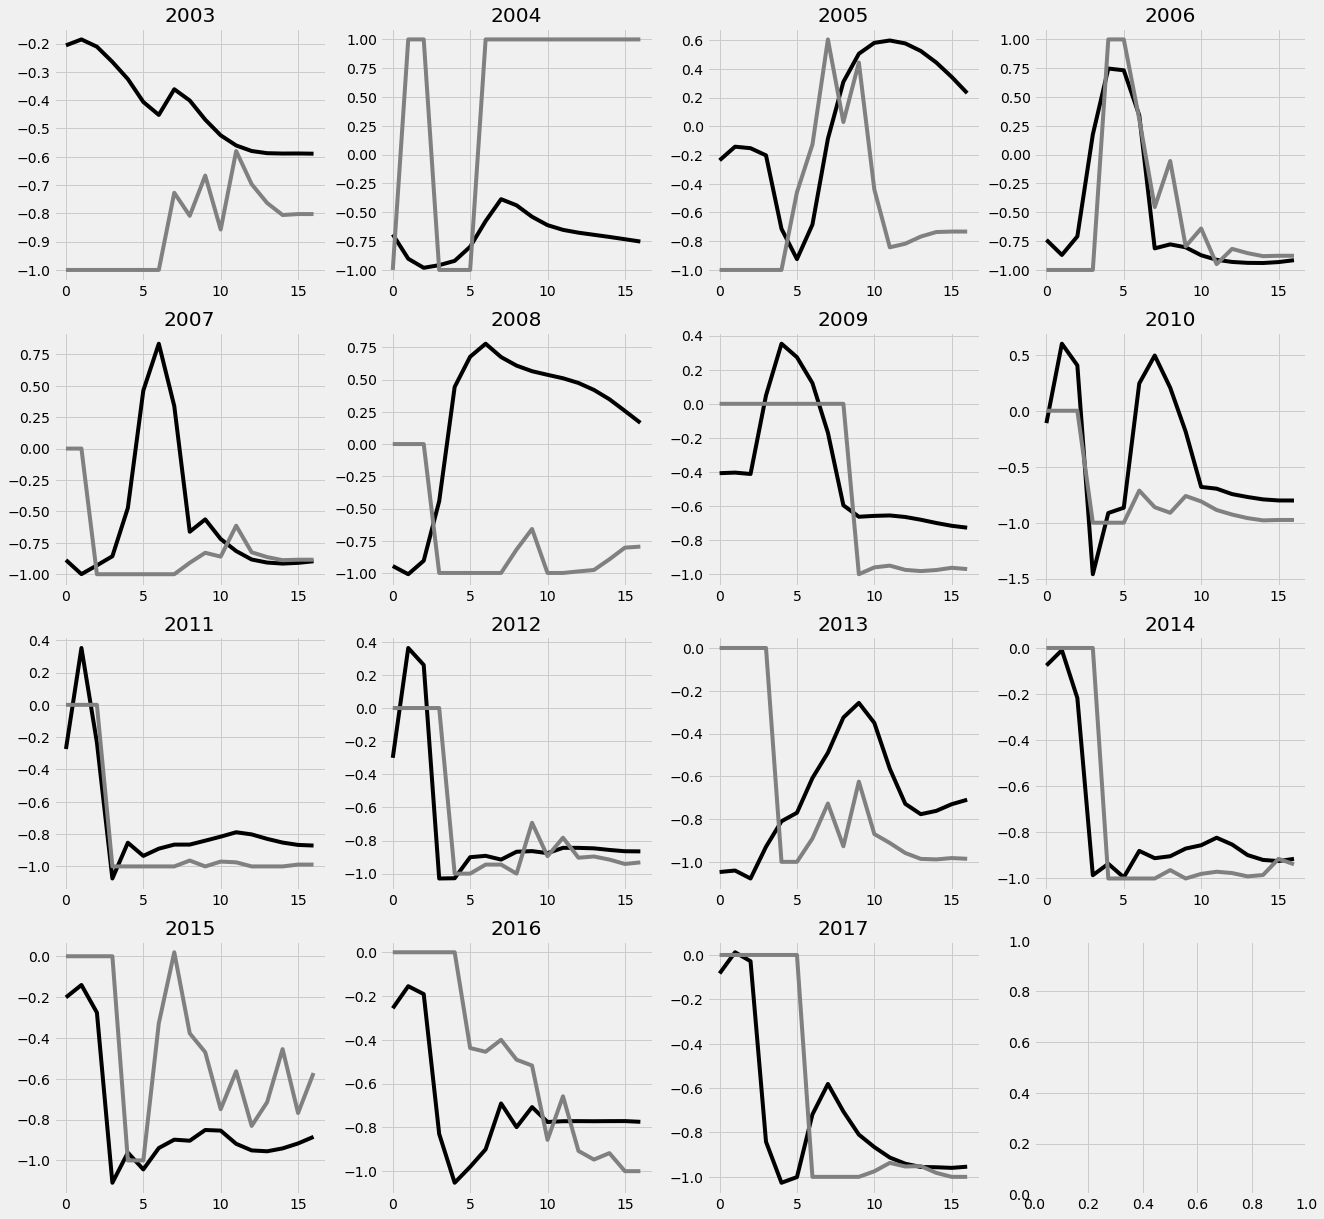

In [282]:
from sklearn.preprocessing import MinMaxScaler

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
Y_scale = np.nan_to_num(Y_scale)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.LSTM(32, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss='mse')


fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(20)
for j, year in enumerate(analysis_years):
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = X_scale[ind]
    train_Y = Y_scale[ind]
    
    test_X = X_scale[j].reshape(1, X_scale.shape[1], X_scale.shape[2])
    test_X[0][:, 0] = np.full(17, 0)
    test_X[0][:, 2] = np.full(17, 0)
    test_X[0][:, 3] = np.full(17, 0)
    test_X[0][8:, 1] = np.full(9, 0)
    test_Y = Y_scale[j].reshape(1, Y_scale.shape[1], Y_scale.shape[2])
    
    history = model.fit(train_X, train_Y, 
                    epochs=500, batch_size=16,)
    
    train_predictions = model.predict(train_X)

    # Train RMSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    print('###################')
    print(f'Train MSE for {year} is {train_mse}')
    print(f'Test MSE for {year} is {test_mse}')
    print('###################')
    
    jx = np.unravel_index(j, ax.shape)
    ax[jx].plot(test_predictions[0], color='black')
    ax[jx].plot(test_Y[0], color='gray')
    ax[jx].set_title(year)

#### First two months of all data

Epoch 1/500
14/14 [==============================] - 11s 778ms/sample - loss: 0.6090
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5829
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5408
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.5022
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4524
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.4370
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3931
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3386
Epoch 9/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3052
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.2942
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.2735
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.3112
Epoch 13/5

Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1617
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1652
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1725
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1868
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1707
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1684
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1777
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1766
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1614
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1675
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1648
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1297
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1379
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1376
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1457
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1358
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1455
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1451
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1424
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1467
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1414
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1486
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1265
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1147
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1119
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1208
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1176
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1192
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1036
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1291
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1118
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1126
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1108
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0949
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1051
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0897
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1074
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0846
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1057
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1033
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0924
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0986
Epoch 403/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.1024
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0904
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0851
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0953
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0993
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0957
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0804
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0864
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0884
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0843
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0898
###################
Train MSE for 2003 is 0.053223670697795634
Test MSE for 2003 is 0.2236751954385302
###################
Epoch 1/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0683
Epoch 2/500
14/14 [====================

Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0607
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0856
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0618
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0682
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0632
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0596
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0664
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0633
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0587
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0581
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0601
Epoch 101/500
14/14 [==============================] - 0s 1ms/sample - loss: 0.0632
Ep

Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0536
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0501
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0572
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0548
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0537
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0535
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0609
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0546
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0556
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0580
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0505
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0466
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0523
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0452
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0464
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0495
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0460
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0462
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0441
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0439
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0426
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0529
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0442
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0458
Epoch 386/500
14/14 [==============================] - 0s 4ms/sample - loss: 0.0440
Epoch 387/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0434
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0366
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0428
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0423
Epoch 391/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0544
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0437
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0415
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0486
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 482/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0449
Epoch 484/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0463
Epoch 485/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0465
Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0450
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0468
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0402
Epoch 489/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0309
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0444
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0406
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0698
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0687
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0623
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0699
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0675
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0699
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0689
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0661
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0580
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0642
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0609
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0742
Epoch 91/500
14/1

Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0550
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0657
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0517
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0558
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0520
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0555
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0577
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0617
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0586
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0566
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0574
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0488
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0481
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0545
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0471
Epoch 279/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0564
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0548
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0595
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0516
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0496
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0547
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0479
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0529
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0510
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0515
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0408
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0487
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0427
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0519
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0532
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0533
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0461
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0517
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 471/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0442
Epoch 472/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0460
Epoch 473/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0476
Epoch 474/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0435
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0511
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0452
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0429
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0385
Epoch 480/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0416
Epoch 481/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0463
Epoch 482/500
14/14 [==============================] - 0s 3ms/sample - loss:

Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0435
Epoch 69/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0372
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0369
Epoch 72/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0320
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 74/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0417
Epoch 75/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0424
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0470
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 78/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0356
Epoch 79/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0387
Epoc

Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0374
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0351
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0316
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0425
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0342
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0349
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0344
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0434
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0470
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0379
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0474
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0367
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0326
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0403
Epoch 364/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0344
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0365
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0310
Epoch 369/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0365
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0331
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0323
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0292
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0308
Epoch 463/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0418
Epoch 464/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0317
Epoch 465/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0263
Epoch 466/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0325
Epoch 467/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0303
Epoch 468/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0347
Epoch 469/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0289
Epoch 470/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0337
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0359
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0394
Epoch 59/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0324
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0421
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 63/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0317
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0445
Epoch 65/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0338
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0414
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0348
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0340
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0349
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0293
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0339
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0400
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0377
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 

Epoch 253/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0274
Epoch 254/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0352
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0343
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0391
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0389
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0375
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0325
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0312
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0329
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0289
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0334
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 48/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0338
Epoch 49/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0349
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0362
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoc

Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 147/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 148/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0314
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0296
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0293
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0384
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0325
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 245/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0301
Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0294
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0263
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0349
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 343/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 344/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 439/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0254
Epoch 440/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0242
Epoch 441/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 442/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0259
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0315
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 38/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 39/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 40/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 41/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 42/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0423
Epoch 43/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 44/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 45/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 46/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 47/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0252
Epoc

Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 137/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 138/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0324
Epoch 139/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0368
Epoch 140/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 141/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 142/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 143/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 144/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 145/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 146/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 235/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 236/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 237/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 238/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 239/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0302
Epoch 240/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0229
Epoch 241/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 242/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 243/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 244/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 333/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0313
Epoch 334/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 335/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 336/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 337/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 338/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0330
Epoch 339/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 340/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 341/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 342/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 429/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0211
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 431/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 432/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 433/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 434/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 435/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 436/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 437/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 438/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0306
Epoch 439/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0227
Epoch 440/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 28/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 29/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 30/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 31/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0266
Epoch 32/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 33/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 34/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 35/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0287
Epoch 36/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 37/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoc

Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 127/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 128/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 129/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 130/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 131/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 132/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 133/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0254
Epoch 134/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 135/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 136/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 225/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 226/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 227/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 228/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 229/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 230/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 231/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 232/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 233/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 234/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 323/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 324/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 325/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 326/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 327/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 328/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 329/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 330/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 331/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 332/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 421/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 422/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 423/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 424/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 425/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 426/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0189
Epoch 427/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0275
Epoch 428/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 429/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 430/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 17/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 18/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 19/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 20/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 21/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 22/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 23/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 24/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 25/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0271
Epoch 26/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 27/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoc

Epoch 115/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 116/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0164
Epoch 117/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 118/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 119/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 120/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 121/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 122/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 123/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 124/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 125/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 126/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 214/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0242
Epoch 215/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 216/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 217/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 218/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 219/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 220/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 221/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 222/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 223/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0168
Epoch 224/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 312/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 313/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 314/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 315/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 316/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 317/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0247
Epoch 318/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 319/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 320/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 321/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 322/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 410/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 411/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 412/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 413/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 414/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 415/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 416/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 417/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 418/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 419/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 420/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 6/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0336
Epoch 7/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0163
Epoch 8/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 9/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0194
Epoch 10/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0282
Epoch 11/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 12/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 13/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 14/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 15/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 16/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 17/500
14/14 [=

Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 106/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 107/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 108/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 109/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 110/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0260
Epoch 111/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0286
Epoch 112/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 113/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0168
Epoch 114/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0230
Epoch 115/500
14/14 [==============================] - 0s 3ms/sample - loss:

Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 204/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0297
Epoch 205/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 206/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 207/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0167
Epoch 208/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0281
Epoch 209/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 210/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 211/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 212/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 213/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 302/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 303/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 304/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 305/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 306/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 307/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 308/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0261
Epoch 309/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 310/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0303
Epoch 311/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 400/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 401/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 402/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 403/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 404/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 405/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 406/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 407/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 408/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 409/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 498/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0285
Epoch 499/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0167
Epoch 500/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
###################
Train MSE for 2012 is 0.0029124299854801465
Test MSE for 2012 is 0.003589242093678526
###################
Epoch 1/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 2/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 3/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 4/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 5/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0253
Epoch 6/500
14/14 [=========================

Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 95/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 96/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 97/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoch 98/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 99/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0239
Epoch 100/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 101/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0220
Epoch 102/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 103/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0238
Epoch 104/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 105/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.018

Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 193/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 194/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0250
Epoch 195/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0196
Epoch 196/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 197/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 198/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 199/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0272
Epoch 200/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 201/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 202/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 203/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 291/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0268
Epoch 292/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 293/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 294/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0231
Epoch 295/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 296/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 297/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 298/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 299/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0264
Epoch 300/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0257
Epoch 301/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 389/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 390/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 391/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 392/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 393/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0175
Epoch 394/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 395/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0191
Epoch 396/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 397/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 398/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0215
Epoch 399/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 486/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 487/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 488/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 489/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 490/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 491/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 492/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0189
Epoch 493/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 494/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 495/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 496/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 497/500
14/14 [==============================] - 0s 2ms/sample - loss:

14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 84/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0206
Epoch 85/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 86/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 87/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 88/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 89/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 90/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 91/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 92/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 93/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0197
Epoch 94/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0251
Epoch 95/500
14/1

Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 182/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 183/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 184/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 185/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 186/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 187/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 188/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0165
Epoch 189/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 190/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 191/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 192/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 280/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 281/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0270
Epoch 282/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 283/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0240
Epoch 284/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0164
Epoch 285/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 286/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0167
Epoch 287/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0165
Epoch 288/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 289/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 290/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0174
Epoch 378/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0187
Epoch 379/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 380/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 381/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 382/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 383/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 384/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0230
Epoch 385/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 386/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 387/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 388/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 476/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 477/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 478/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0166
Epoch 479/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0284
Epoch 480/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0262
Epoch 481/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 482/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0158
Epoch 483/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 484/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0204
Epoch 485/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0178
Epoch 486/500
14/14 [==============================] - 0s 3ms/sample - loss:

Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 73/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 74/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 75/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 76/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 77/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 78/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 79/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0170
Epoch 80/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 81/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 82/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 83/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoc

Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 171/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 172/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 173/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0226
Epoch 174/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 175/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 176/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 177/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 178/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 179/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0234
Epoch 180/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 181/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 269/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 270/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0143
Epoch 271/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 272/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 273/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 274/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 275/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0277
Epoch 276/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 277/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0167
Epoch 278/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoch 279/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 367/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 368/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0185
Epoch 369/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 370/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 371/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0171
Epoch 372/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0280
Epoch 373/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 374/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 375/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0145
Epoch 376/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 377/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0203
Epoch 465/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0183
Epoch 466/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0205
Epoch 467/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0180
Epoch 468/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0279
Epoch 469/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 470/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0146
Epoch 471/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0190
Epoch 472/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0155
Epoch 473/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0172
Epoch 474/500
14/14 [==============================] - 0s 3ms/sample - loss: 0.0184
Epoch 475/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 62/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 63/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 64/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 65/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0244
Epoch 66/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 67/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 68/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 69/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 70/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0204
Epoch 71/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 72/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0164
Epoc

Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0248
Epoch 160/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 161/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 162/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0216
Epoch 163/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 164/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0211
Epoch 165/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 166/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 167/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 168/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 169/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 170/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 258/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 259/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0152
Epoch 260/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0193
Epoch 261/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0186
Epoch 262/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0157
Epoch 263/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 264/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0245
Epoch 265/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 266/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0288
Epoch 267/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 268/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 356/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0168
Epoch 357/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 358/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 359/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 360/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 361/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0217
Epoch 362/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 363/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0182
Epoch 364/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0184
Epoch 365/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 366/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0228
Epoch 454/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 455/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 456/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0179
Epoch 457/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 458/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 459/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0258
Epoch 460/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0174
Epoch 461/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0199
Epoch 462/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 463/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 464/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 50/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 51/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 52/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 53/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 54/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0241
Epoch 55/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 56/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 57/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0172
Epoch 58/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 59/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 60/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0210
Epoch 61/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0235
Epoc

14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 149/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0180
Epoch 150/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0212
Epoch 151/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 152/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0149
Epoch 153/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0243
Epoch 154/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 155/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0183
Epoch 156/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 157/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 158/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0160
Epoch 159/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 

Epoch 246/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 247/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 248/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0214
Epoch 249/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0209
Epoch 250/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 251/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 252/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0169
Epoch 253/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0145
Epoch 254/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0177
Epoch 255/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 256/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0218
Epoch 257/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 344/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0200
Epoch 345/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 346/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 347/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0178
Epoch 348/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0198
Epoch 349/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0194
Epoch 350/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0262
Epoch 351/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 352/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 353/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 354/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0246
Epoch 355/500
14/14 [==============================] - 0s 2ms/sample - loss:

Epoch 442/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0224
Epoch 443/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 444/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0201
Epoch 445/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0223
Epoch 446/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0192
Epoch 447/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0225
Epoch 448/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0162
Epoch 449/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 450/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0207
Epoch 451/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0213
Epoch 452/500
14/14 [==============================] - 0s 2ms/sample - loss: 0.0173
Epoch 453/500
14/14 [==============================] - 0s 2ms/sample - loss:

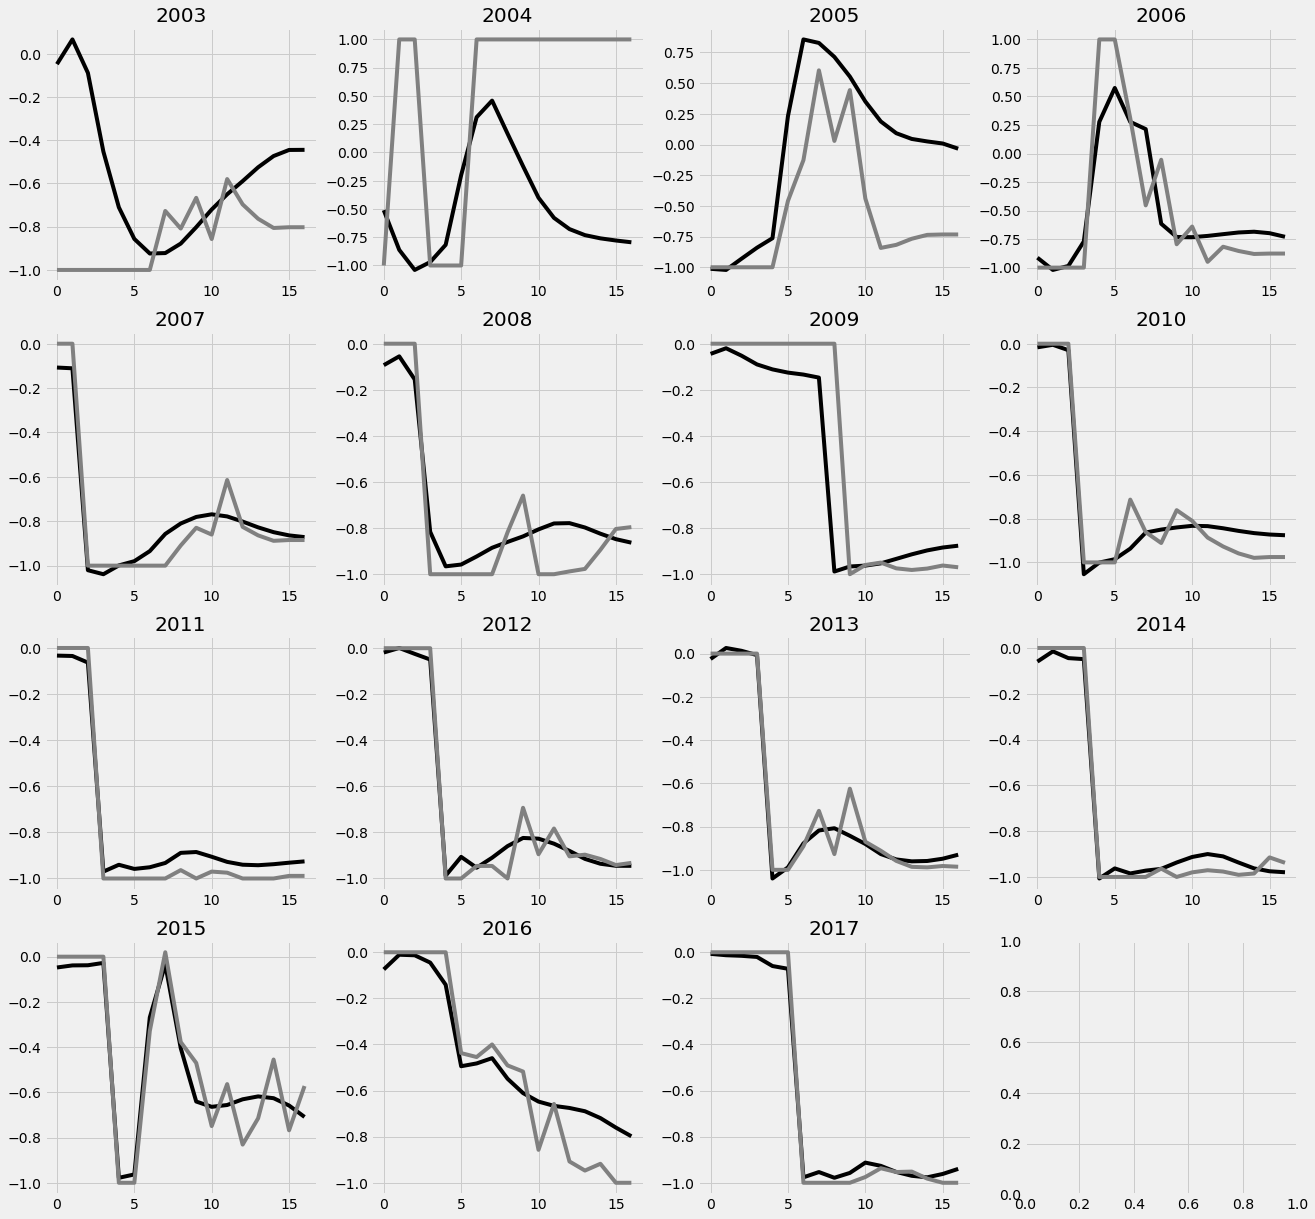

In [283]:
from sklearn.preprocessing import MinMaxScaler

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
Y_scale = np.nan_to_num(Y_scale)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.LSTM(32, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss='mse')


fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(20)
for j, year in enumerate(analysis_years):
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = X_scale[ind]
    train_Y = Y_scale[ind]
    
    test_X = X_scale[j].reshape(1, X_scale.shape[1], X_scale.shape[2])
    test_X[0][8:, 0] = np.full(9, 0)
    test_X[0][8:, 2] = np.full(9, 0)
    test_X[0][8:, 3] = np.full(9, 0)
    test_X[0][8:, 1] = np.full(9, 0)
    test_Y = Y_scale[j].reshape(1, Y_scale.shape[1], Y_scale.shape[2])
    
    history = model.fit(train_X, train_Y, 
                    epochs=500, batch_size=16,)
    
    train_predictions = model.predict(train_X)

    # Train RMSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    print('###################')
    print(f'Train MSE for {year} is {train_mse}')
    print(f'Test MSE for {year} is {test_mse}')
    print('###################')
    
    jx = np.unravel_index(j, ax.shape)
    ax[jx].plot(test_predictions[0], color='black')
    ax[jx].plot(test_Y[0], color='gray')
    ax[jx].set_title(year)

## Parametric

### ARIMA